In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer, weighted_quantile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
import os
import seaborn as sns

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


## Reference trajectory

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)

In [4]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)

In [5]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [6]:
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(250, 3, 5)


In [7]:
# def f(beta, ntot, ninf):
#     p = 1 - tf.math.exp(tf.math.log(1 - tf.reshape(beta, (-1, 1)))
#                           * tf.reduce_sum((ninf) / ntot[:, :, tf.newaxis], axis=2))
#     return p
# p = []
# for i in np.linspace(0,1,10):
#     ninf = np.zeros((1,M), dtype = np.float32)
#     ninf[0,0] = i
#     print (f(0.01, np.ones((1,M), dtype = np.float32),ninf))
#     p.append(f(0.01, np.ones((1,M), dtype = np.float32),ninf))


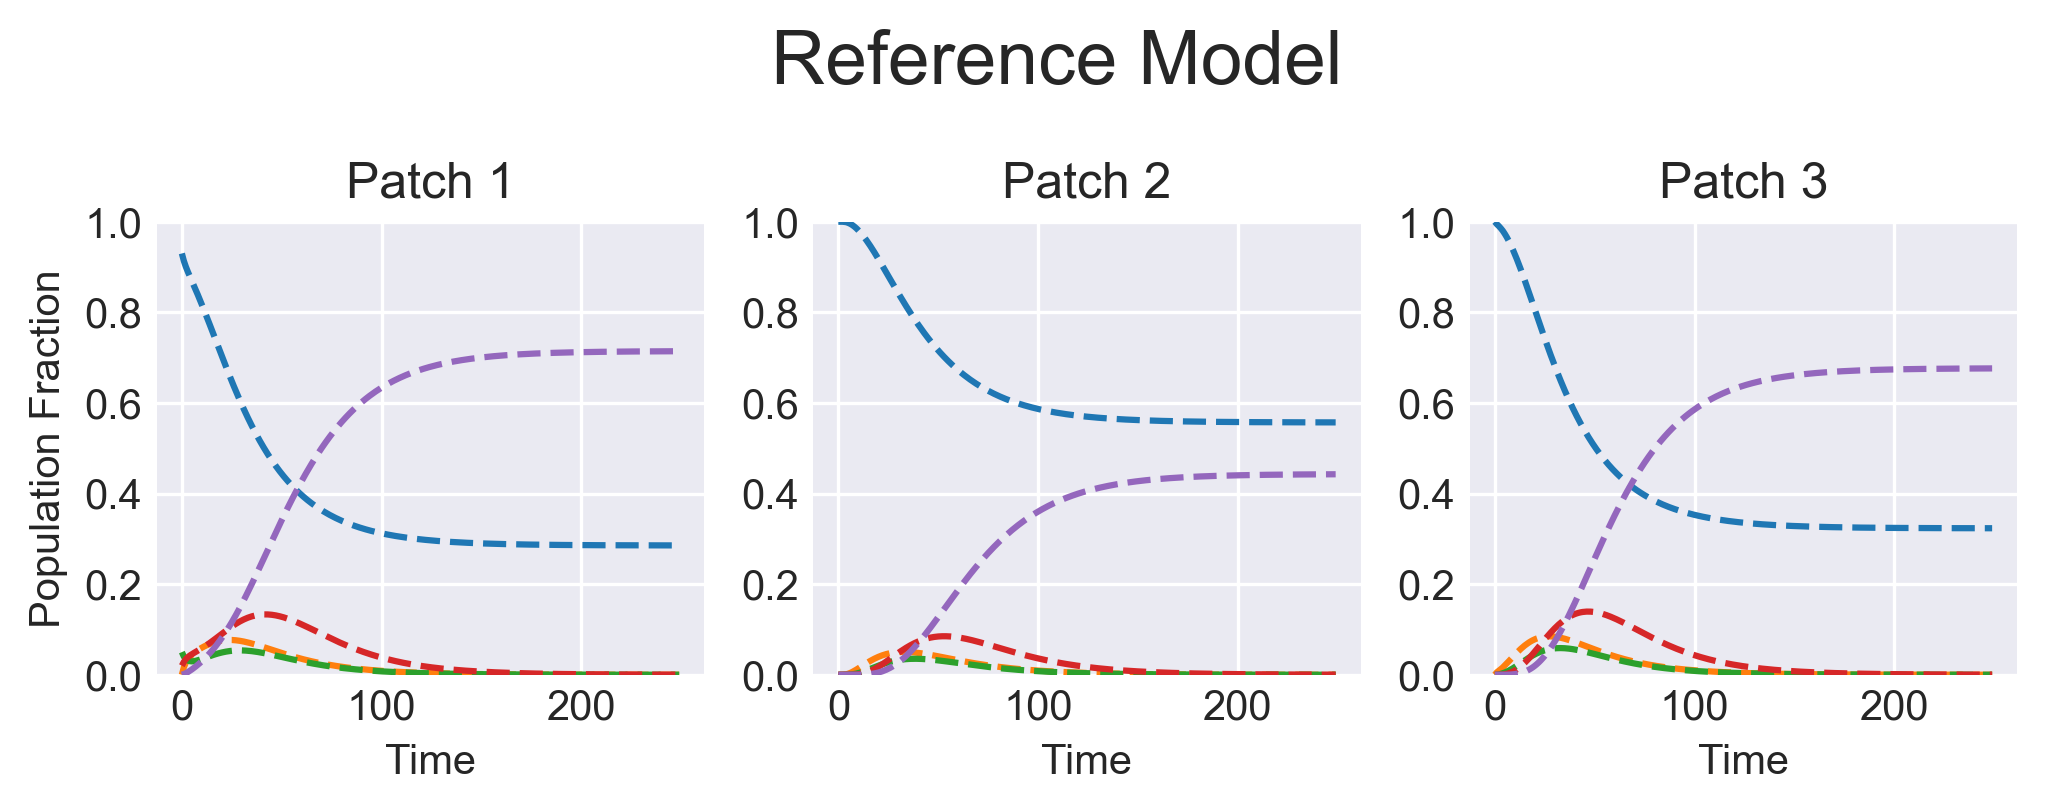

tf.Tensor(
[[9.3000001e-01 0.0000000e+00 5.0000001e-02 2.0000000e-02 0.0000000e+00]
 [9.1351068e-01 1.6489347e-02 4.0000003e-02 2.8571427e-02 1.4285714e-03]
 [9.0063554e-01 2.7008828e-02 3.4355622e-02 3.4530610e-02 3.4693875e-03]
 ...
 [2.8569031e-01 9.8567813e-05 8.5043037e-05 4.6003459e-04 7.1366608e-01]
 [2.8567964e-01 9.5171024e-05 8.2115548e-05 4.4418356e-04 7.1369892e-01]
 [2.8566933e-01 9.1897942e-05 7.9288300e-05 4.2887928e-04 7.1373063e-01]], shape=(230, 5), dtype=float32)
tf.Tensor(
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [5.57283759e-01 1.12182679e-04 9.67724918e-05 5.21353155e-04
  4.41985935e-01]
 [5.57271600e-01 1.08315973e-04 9.34440905e-05 5.03468153e-04
  4.42023188e-01]
 [5.57259798e-01 1.04594495e-04 9.02289903e-05 4.86194942e-04
  4.42059159e-01]], shape=(230, 5),

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
print (ref_traj[:-20:,0,:])
print (ref_traj[:-20:,1,:])
print (ref_traj[:-20:,1,:] == ref_traj[:-20:,0,:])
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))

## Sample SEAIR Trajectories

Creating a set of trajectories.

In [9]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 1)
tmat.add_transition('A', 'I', 2, 4)
tmat.add_transition('I', 'R', 14, 3)
full_compartments = ['S'] + compartments

In [10]:
# starting fractions probabilities
start_logits = np.zeros((M)) #anywhere
start_logits[0]=np.log(0.9)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_var = 0.9
hyper_pram.beta_start = 0.01
hyper_pram.beta_high = 0.15
hyper_pram.beta_low = 0.001
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.4
hyper_pram.start_var = 0.5
# hyper_pram.R_var = 0.9
# hyper_pram.start_high = 0.01
# R_sample_norm = np.array([[0.1, 0.8, 0.1],
#              [0.05, 0.8, 0.15],
#              [0.01, 0.12, 0.87]])
# # R_sample_norm = R_sample / np.sum(R_sample, axis=1)

In [11]:
param_model = maxentep.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)

In [12]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 2048
batches = 4
batch_size = N*batches
outs = []
timesteps = 250
# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.01s/it]

(8192, 250, 3, 5)


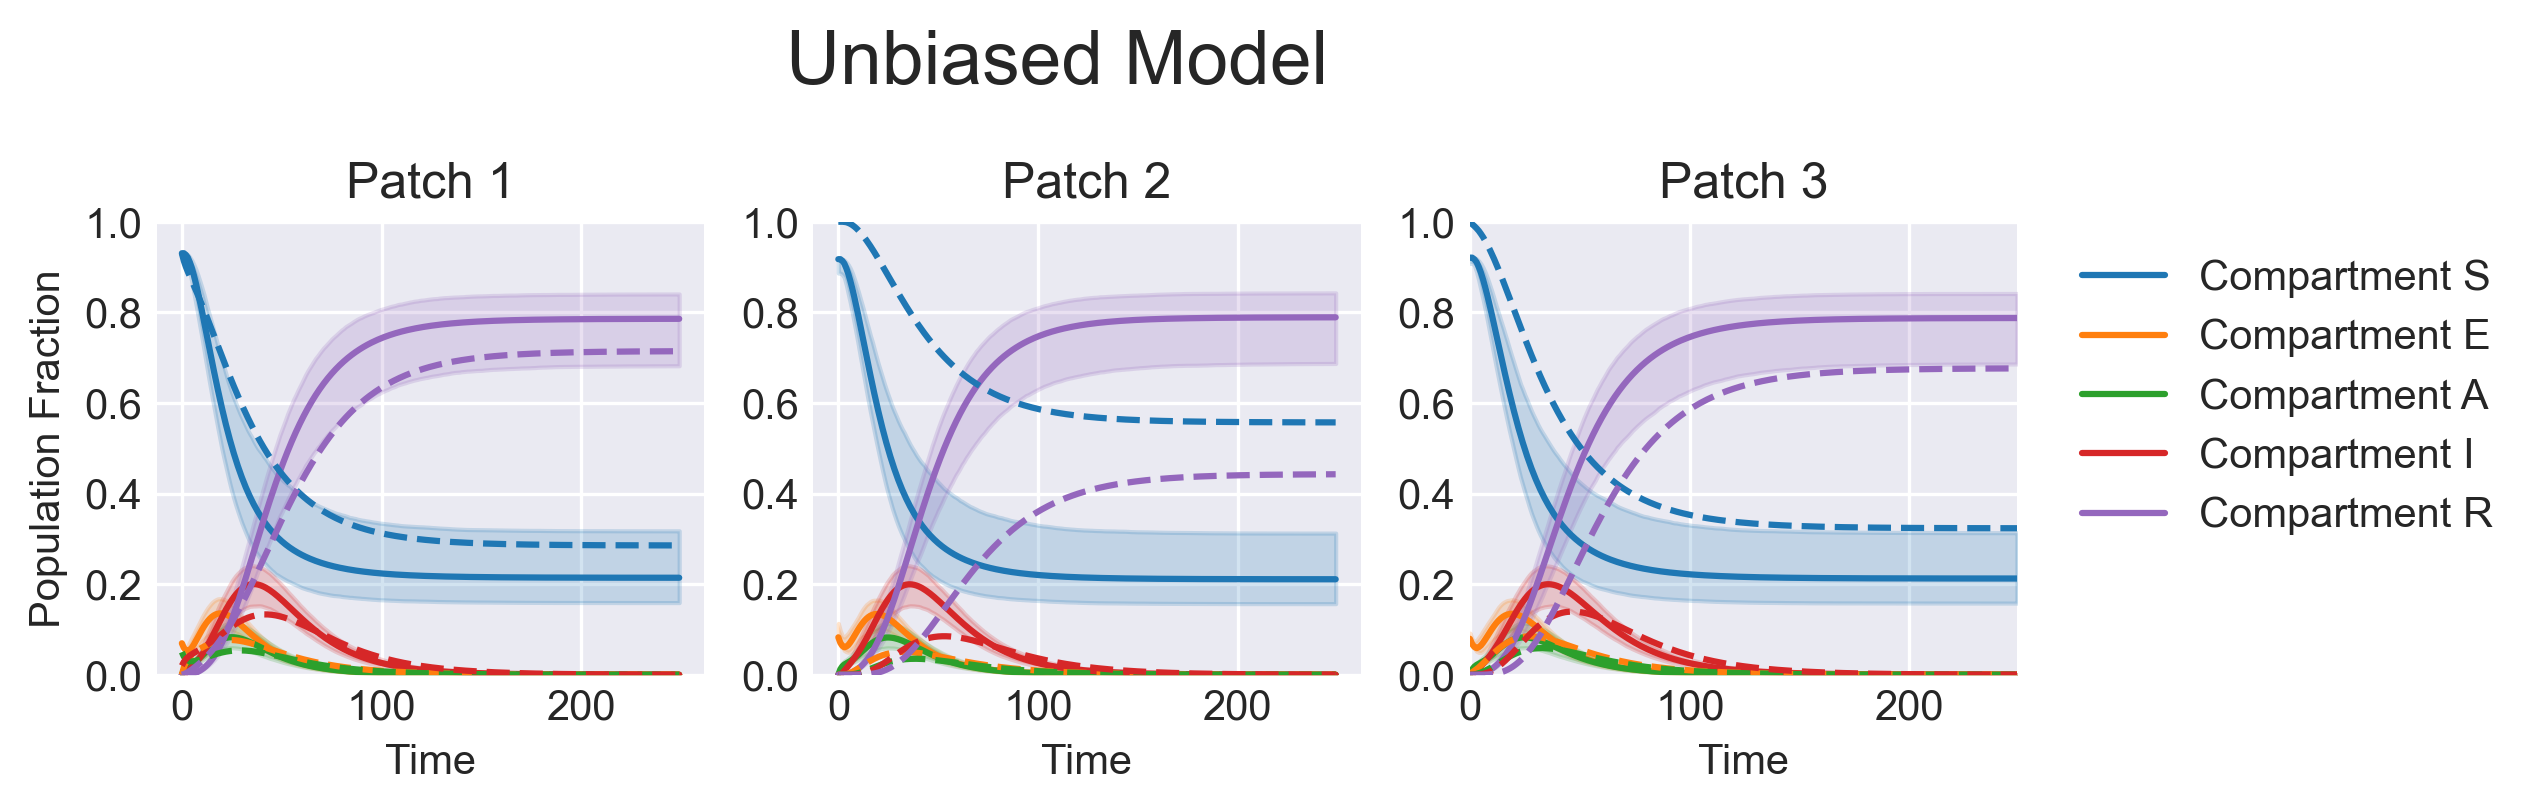

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

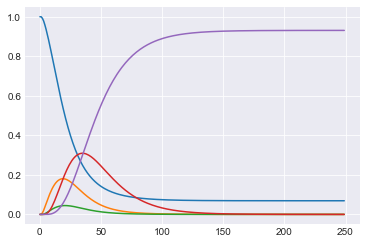

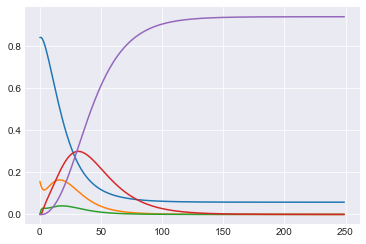

In [14]:
plt.plot(trajs[1234,:,1,:])
plt.show()
plt.plot(trajs[1234,:,2,:])
# print (trajs[:-20:,1,:] == trajs[:-20:,0,:])
# fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
# # fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
# axs[0].plot(trajs[0,:,0,:])
# axs[1].plot(trajs[100,:,1,:])
# # maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# for i in range (M):
#     plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
#     axs[i].plot(ref_traj[:,i],linestyle='--')
# axs[0].set_ylabel('Population Fraction')
# plt.show()

## Make restraints from reference trajectory

In [15]:
npoints = 5
np.random.seed(0)
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list, restraints_dict = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300838 0.10784743734654037
45 0.13207568 0.15260560737936643
31 0.121692084 0.12889426233404105
80 0.06942841 0.1421420820039372
17 0.08018887 0.11824075668734235


In [16]:
print (restraints_dict)

{'npoints': 5, 'restrained_patches': [0], 'restrained_compartments': [3]}


## Visualizing Restraints

Text(0, 0.5, 'Population Fraction')

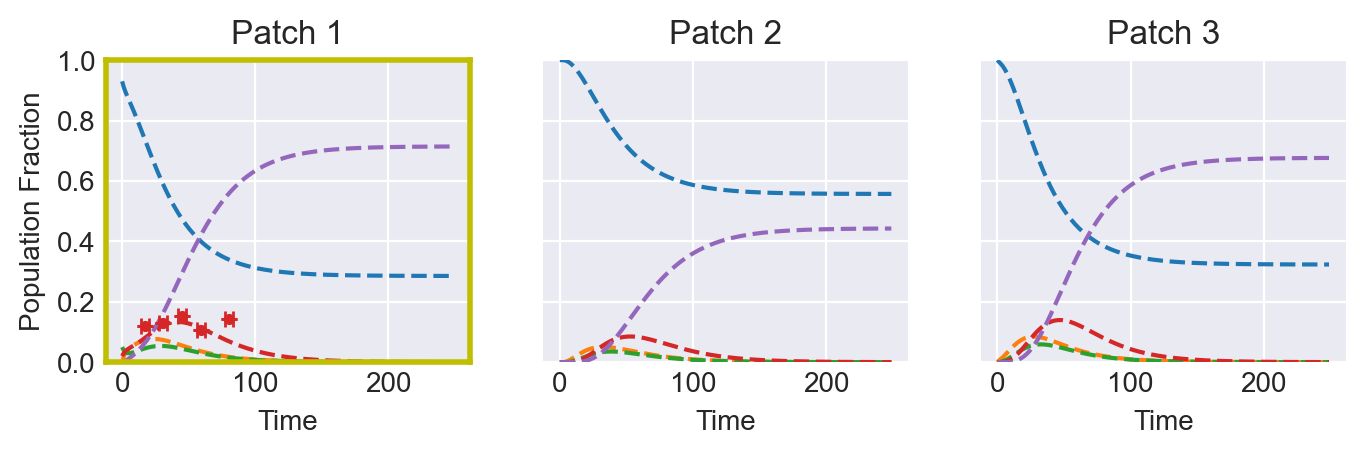

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=M, sharex=True,
                           sharey=True, figsize=(8,2), dpi =200)
for i in range(M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1),ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')


In [18]:
me_model = maxentep.MaxentModel(restraints, ref_traj=ref_traj[np.newaxis,:,:,:], trajs=trajs, population_fraction=population_fraction)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
print (ref_traj[np.newaxis,:,:,:].shape)
print (population_fraction.shape)
print (trajs.shape)

(1, 250, 3, 5)
(3,)
(8192, 250, 3, 5)


In [19]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [20]:
me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000, callbacks=[CustomCallback()])

Epoch 1/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0026 - ref-error-metric: 1.5241 - ref-error: 1.5241 - weight-entropy: 9.0097
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-error-metric: 1.5260 - ref-error: 1.5260 - weight-entropy: 9.0098
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-error-metric: 1.5259 - ref-error: 1.5259 - weight-entropy: 9.0099
Epoch 4/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0026 - ref-error-metric: 1.5287 - ref-error: 1.5287 - weight-entropy: 9.0100
Epoch 5/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0026 - ref-error-metric: 1.5264 - ref-error: 1.5264 - weight-entropy: 9.0101
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0026 - ref-error-metric: 1.5263 - ref-error: 1.5263 - weight-entropy: 9.0102
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0026 - ref-err

1/1 [==============================] - 0s 927us/step - loss: 0.0023 - ref-error-metric: 1.5286 - ref-error: 1.5286 - weight-entropy: 9.0068
Epoch 55/1000
1/1 [==============================] - 0s 986us/step - loss: 0.0023 - ref-error-metric: 1.5308 - ref-error: 1.5308 - weight-entropy: 9.0066
Epoch 56/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0023 - ref-error-metric: 1.5260 - ref-error: 1.5260 - weight-entropy: 9.0064
Epoch 57/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - ref-error-metric: 1.5263 - ref-error: 1.5263 - weight-entropy: 9.0061
Epoch 58/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0023 - ref-error-metric: 1.5287 - ref-error: 1.5287 - weight-entropy: 9.0059
Epoch 59/1000
1/1 [==============================] - 0s 990us/step - loss: 0.0023 - ref-error-metric: 1.5303 - ref-error: 1.5303 - weight-entropy: 9.0057
Epoch 60/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0023 - ref-error-me

1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metric: 1.5211 - ref-error: 1.5211 - weight-entropy: 8.9911
Epoch 108/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metric: 1.5114 - ref-error: 1.5114 - weight-entropy: 8.9908
Epoch 109/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - ref-error-metric: 1.5157 - ref-error: 1.5157 - weight-entropy: 8.9904
Epoch 110/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0021 - ref-error-metric: 1.5297 - ref-error: 1.5297 - weight-entropy: 8.9901
Epoch 111/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - ref-error-metric: 1.5371 - ref-error: 1.5371 - weight-entropy: 8.9897
Epoch 112/1000
1/1 [==============================] - 0s 973us/step - loss: 0.0021 - ref-error-metric: 1.5258 - ref-error: 1.5258 - weight-entropy: 8.9894
Epoch 113/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - ref-err

1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 1.5259 - ref-error: 1.5259 - weight-entropy: 8.9739
Epoch 161/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0020 - ref-error-metric: 1.5186 - ref-error: 1.5186 - weight-entropy: 8.9736
Epoch 162/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 1.5289 - ref-error: 1.5289 - weight-entropy: 8.9733
Epoch 163/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0020 - ref-error-metric: 1.5222 - ref-error: 1.5222 - weight-entropy: 8.9730
Epoch 164/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0020 - ref-error-metric: 1.5243 - ref-error: 1.5243 - weight-entropy: 8.9727
Epoch 165/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0020 - ref-error-metric: 1.5234 - ref-error: 1.5234 - weight-entropy: 8.9725
Epoch 166/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - ref-er

1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - ref-error-metric: 1.5393 - ref-error: 1.5393 - weight-entropy: 8.9612
Epoch 213/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - ref-error-metric: 1.5226 - ref-error: 1.5226 - weight-entropy: 8.9610
Epoch 214/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0020 - ref-error-metric: 1.5301 - ref-error: 1.5301 - weight-entropy: 8.9608
Epoch 215/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 1.5264 - ref-error: 1.5264 - weight-entropy: 8.9606
Epoch 216/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 1.5209 - ref-error: 1.5209 - weight-entropy: 8.9604
Epoch 217/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0020 - ref-error-metric: 1.5225 - ref-error: 1.5225 - weight-entropy: 8.9602
Epoch 218/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0020 - ref-error

1/1 [==============================] - 0s 999us/step - loss: 0.0020 - ref-error-metric: 1.5228 - ref-error: 1.5228 - weight-entropy: 8.9526
Epoch 266/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 1.5217 - ref-error: 1.5217 - weight-entropy: 8.9525
Epoch 267/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0020 - ref-error-metric: 1.5247 - ref-error: 1.5247 - weight-entropy: 8.9524
Epoch 268/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 1.5232 - ref-error: 1.5232 - weight-entropy: 8.9522
Epoch 269/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0020 - ref-error-metric: 1.5135 - ref-error: 1.5135 - weight-entropy: 8.9521
Epoch 270/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0020 - ref-error-metric: 1.5357 - ref-error: 1.5357 - weight-entropy: 8.9520
Epoch 271/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0020 - ref-er

1/1 [==============================] - 0s 994us/step - loss: 0.0019 - ref-error-metric: 1.5283 - ref-error: 1.5283 - weight-entropy: 8.9469
Epoch 319/1000
1/1 [==============================] - 0s 993us/step - loss: 0.0019 - ref-error-metric: 1.5237 - ref-error: 1.5237 - weight-entropy: 8.9468
Epoch 320/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metric: 1.5151 - ref-error: 1.5151 - weight-entropy: 8.9467
Epoch 321/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metric: 1.5281 - ref-error: 1.5281 - weight-entropy: 8.9466
Epoch 322/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metric: 1.5418 - ref-error: 1.5418 - weight-entropy: 8.9465
Epoch 323/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5097 - ref-error: 1.5097 - weight-entropy: 8.9465
Epoch 324/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-erro

1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5474 - ref-error: 1.5474 - weight-entropy: 8.9427
Epoch 372/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5229 - ref-error: 1.5229 - weight-entropy: 8.9426
Epoch 373/1000
1/1 [==============================] - 0s 992us/step - loss: 0.0019 - ref-error-metric: 1.5211 - ref-error: 1.5211 - weight-entropy: 8.9425
Epoch 374/1000
1/1 [==============================] - 0s 972us/step - loss: 0.0019 - ref-error-metric: 1.5208 - ref-error: 1.5208 - weight-entropy: 8.9424
Epoch 375/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5251 - ref-error: 1.5251 - weight-entropy: 8.9424
Epoch 376/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5087 - ref-error: 1.5087 - weight-entropy: 8.9423
Epoch 377/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-

1/1 [==============================] - 0s 0s/step - loss: 0.0019 - ref-error-metric: 1.5310 - ref-error: 1.5310 - weight-entropy: 8.9390
Epoch 425/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metric: 1.5092 - ref-error: 1.5092 - weight-entropy: 8.9389
Epoch 426/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 1.5177 - ref-error: 1.5177 - weight-entropy: 8.9389
Epoch 427/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0019 - ref-error-metric: 1.5310 - ref-error: 1.5310 - weight-entropy: 8.9388
Epoch 428/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0019 - ref-error-metric: 1.5210 - ref-error: 1.5210 - weight-entropy: 8.9387
Epoch 429/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5123 - ref-error: 1.5123 - weight-entropy: 8.9387
Epoch 430/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-err

1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - ref-error-metric: 1.5229 - ref-error: 1.5229 - weight-entropy: 8.9355
Epoch 478/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 1.5261 - ref-error: 1.5261 - weight-entropy: 8.9355
Epoch 479/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 1.5213 - ref-error: 1.5213 - weight-entropy: 8.9354
Epoch 480/1000
1/1 [==============================] - 0s 993us/step - loss: 0.0019 - ref-error-metric: 1.5300 - ref-error: 1.5300 - weight-entropy: 8.9353
Epoch 481/1000
1/1 [==============================] - 0s 994us/step - loss: 0.0019 - ref-error-metric: 1.5377 - ref-error: 1.5377 - weight-entropy: 8.9353
Epoch 482/1000
1/1 [==============================] - 0s 995us/step - loss: 0.0019 - ref-error-metric: 1.5419 - ref-error: 1.5419 - weight-entropy: 8.9352
Epoch 483/1000
1/1 [==============================] - 0s 976us/step - loss: 0.0019 - re

1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5462 - ref-error: 1.5462 - weight-entropy: 8.9321
Epoch 530/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0019 - ref-error-metric: 1.5614 - ref-error: 1.5614 - weight-entropy: 8.9320
Epoch 531/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5329 - ref-error: 1.5329 - weight-entropy: 8.9320
Epoch 532/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - ref-error-metric: 1.5347 - ref-error: 1.5347 - weight-entropy: 8.9319
Epoch 533/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - ref-error-metric: 1.5382 - ref-error: 1.5382 - weight-entropy: 8.9318
Epoch 534/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5508 - ref-error: 1.5508 - weight-entropy: 8.9318
Epoch 535/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - ref-error-metr

1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 1.5301 - ref-error: 1.5301 - weight-entropy: 8.9286
Epoch 583/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 1.5290 - ref-error: 1.5290 - weight-entropy: 8.9285
Epoch 584/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5413 - ref-error: 1.5413 - weight-entropy: 8.9284
Epoch 585/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5193 - ref-error: 1.5193 - weight-entropy: 8.9284
Epoch 586/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5264 - ref-error: 1.5264 - weight-entropy: 8.9283
Epoch 587/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5243 - ref-error: 1.5243 - weight-entropy: 8.9282
Epoch 588/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0019 - ref-

1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5160 - ref-error: 1.5160 - weight-entropy: 8.9250
Epoch 636/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5256 - ref-error: 1.5256 - weight-entropy: 8.9249
Epoch 637/1000
1/1 [==============================] - 0s 972us/step - loss: 0.0018 - ref-error-metric: 1.5534 - ref-error: 1.5534 - weight-entropy: 8.9249
Epoch 638/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5200 - ref-error: 1.5200 - weight-entropy: 8.9248
Epoch 639/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5241 - ref-error: 1.5241 - weight-entropy: 8.9247
Epoch 640/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5241 - ref-error: 1.5241 - weight-entropy: 8.9247
Epoch 641/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-

1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5247 - ref-error: 1.5247 - weight-entropy: 8.9214
Epoch 689/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5213 - ref-error: 1.5213 - weight-entropy: 8.9213
Epoch 690/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - ref-error-metric: 1.5339 - ref-error: 1.5339 - weight-entropy: 8.9212
Epoch 691/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5281 - ref-error: 1.5281 - weight-entropy: 8.9212
Epoch 692/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5004 - ref-error: 1.5004 - weight-entropy: 8.9211
Epoch 693/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5406 - ref-error: 1.5406 - weight-entropy: 8.9210
Epoch 694/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref

1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5290 - ref-error: 1.5290 - weight-entropy: 8.9177
Epoch 742/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0018 - ref-error-metric: 1.5378 - ref-error: 1.5378 - weight-entropy: 8.9177
Epoch 743/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 1.5048 - ref-error: 1.5048 - weight-entropy: 8.9176
Epoch 744/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - ref-error-metric: 1.5242 - ref-error: 1.5242 - weight-entropy: 8.9175
Epoch 745/1000
1/1 [==============================] - 0s 986us/step - loss: 0.0018 - ref-error-metric: 1.5099 - ref-error: 1.5099 - weight-entropy: 8.9175
Epoch 746/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - ref-error-metric: 1.5209 - ref-error: 1.5209 - weight-entropy: 8.9174
Epoch 747/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-m

1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5376 - ref-error: 1.5376 - weight-entropy: 8.9141
Epoch 795/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 1.5205 - ref-error: 1.5205 - weight-entropy: 8.9140
Epoch 796/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5291 - ref-error: 1.5291 - weight-entropy: 8.9140
Epoch 797/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5381 - ref-error: 1.5381 - weight-entropy: 8.9139
Epoch 798/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5249 - ref-error: 1.5249 - weight-entropy: 8.9138
Epoch 799/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5309 - ref-error: 1.5309 - weight-entropy: 8.9137
Epoch 800/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - re

1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5312 - ref-error: 1.5312 - weight-entropy: 8.9104
Epoch 848/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5196 - ref-error: 1.5196 - weight-entropy: 8.9104
Epoch 849/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5432 - ref-error: 1.5432 - weight-entropy: 8.9103
Epoch 850/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 1.5198 - ref-error: 1.5198 - weight-entropy: 8.9102
Epoch 851/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5174 - ref-error: 1.5174 - weight-entropy: 8.9102
Epoch 852/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5067 - ref-error: 1.5067 - weight-entropy: 8.9101
Epoch 853/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-me

1/1 [==============================] - 0s 988us/step - loss: 0.0018 - ref-error-metric: 1.5209 - ref-error: 1.5209 - weight-entropy: 8.9068
Epoch 901/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - ref-error-metric: 1.5213 - ref-error: 1.5213 - weight-entropy: 8.9067
Epoch 902/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0018 - ref-error-metric: 1.5236 - ref-error: 1.5236 - weight-entropy: 8.9067
Epoch 903/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 1.5261 - ref-error: 1.5261 - weight-entropy: 8.9066
Epoch 904/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5365 - ref-error: 1.5365 - weight-entropy: 8.9065
Epoch 905/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5299 - ref-error: 1.5299 - weight-entropy: 8.9065
Epoch 906/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-erro

1/1 [==============================] - 0s 991us/step - loss: 0.0018 - ref-error-metric: 1.5375 - ref-error: 1.5375 - weight-entropy: 8.9032
Epoch 953/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-error-metric: 1.5194 - ref-error: 1.5194 - weight-entropy: 8.9031
Epoch 954/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-error-metric: 1.5263 - ref-error: 1.5263 - weight-entropy: 8.9031
Epoch 955/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5293 - ref-error: 1.5293 - weight-entropy: 8.9030
Epoch 956/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-metric: 1.5228 - ref-error: 1.5228 - weight-entropy: 8.9029
Epoch 957/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-error-metric: 1.5265 - ref-error: 1.5265 - weight-entropy: 8.9029
Epoch 958/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - re

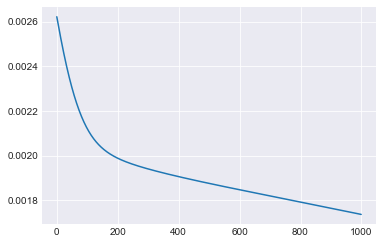

In [21]:
plt.plot(me_history.history['loss'])

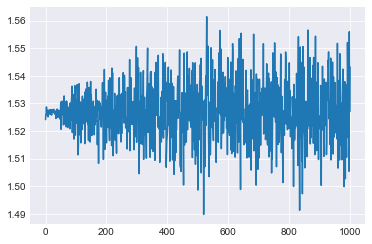

In [22]:
plt.plot(me_history.history['ref-error'])

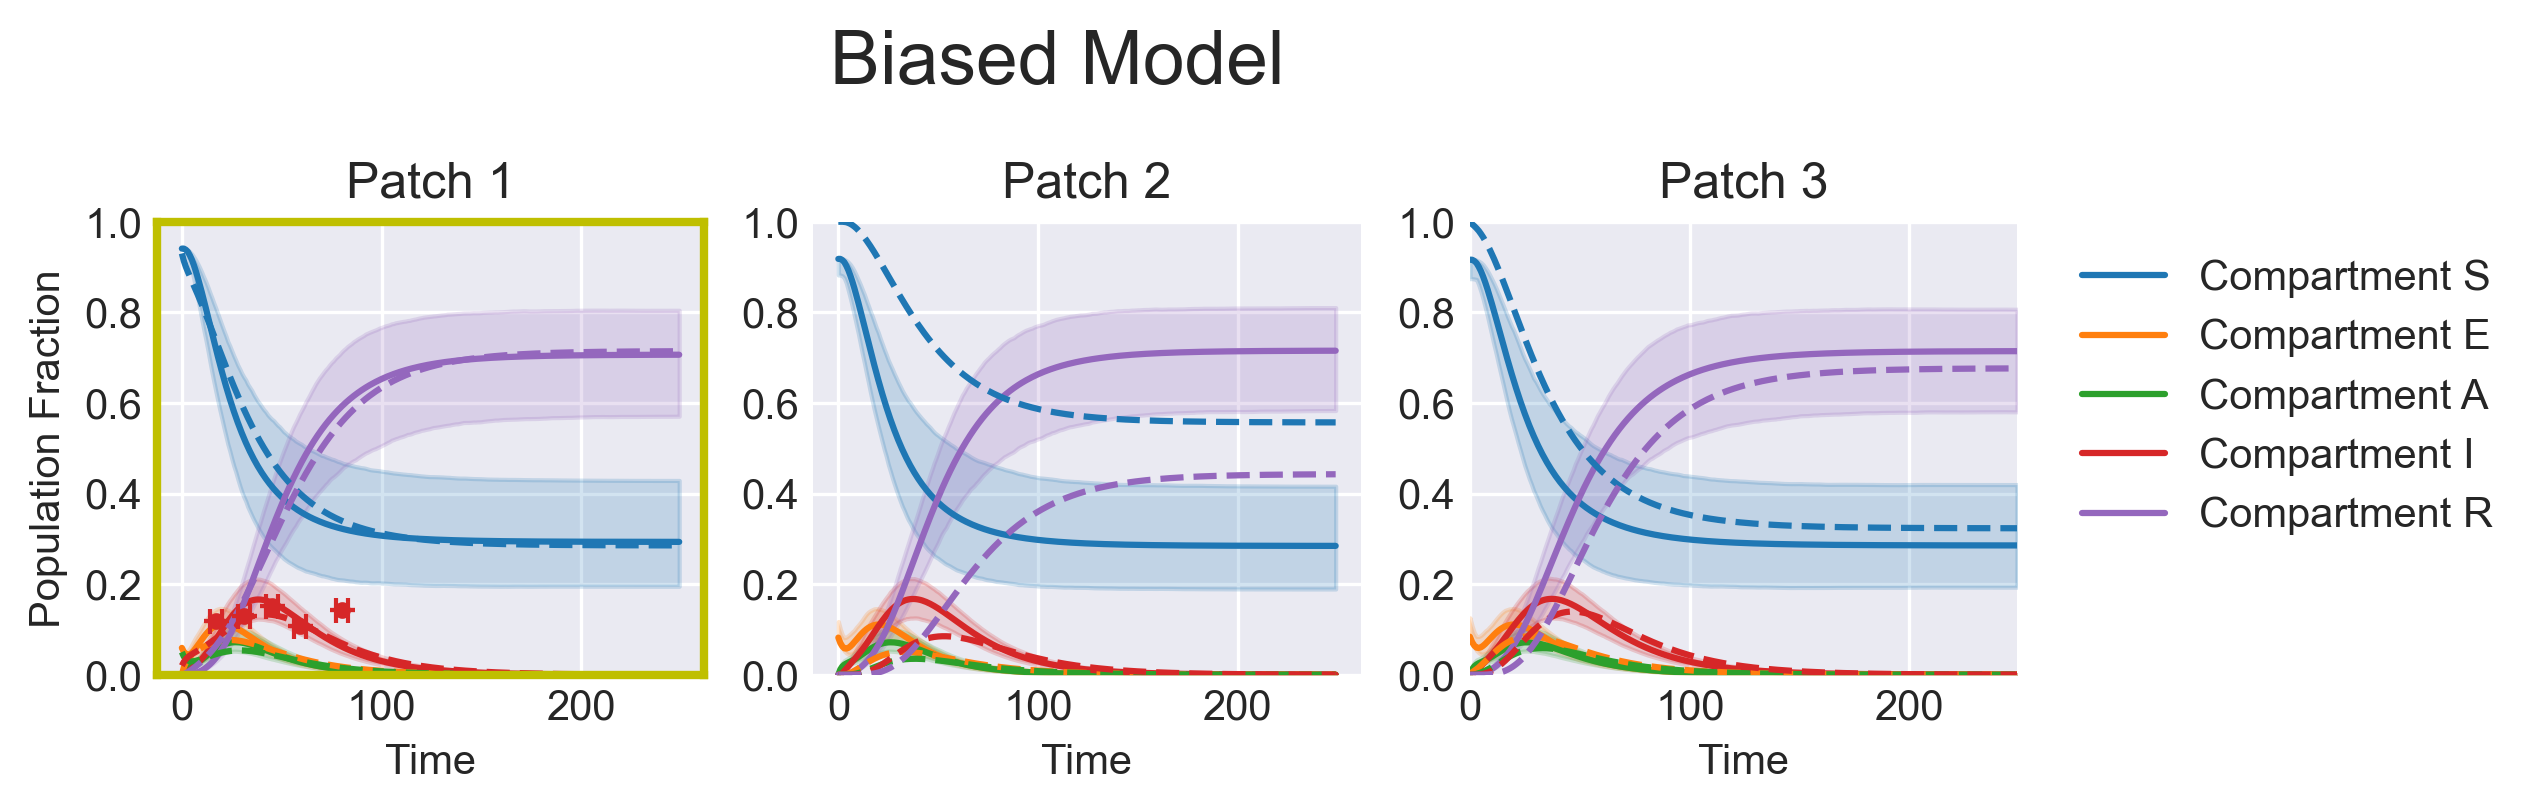

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(me_model.trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,1,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,2,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [24]:
Tmtat = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.05
# start[1,0] = 0.05
beta_start = 0.1
infect = maxentep.ContactInfectionLayer(beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, agreement)

In [25]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(timesteps)
regressed_traj = rmodel.get_traj()

250/250 [==============================] - 40s 158ms/step - loss: 0.0032 - output_2_loss: 0.0032


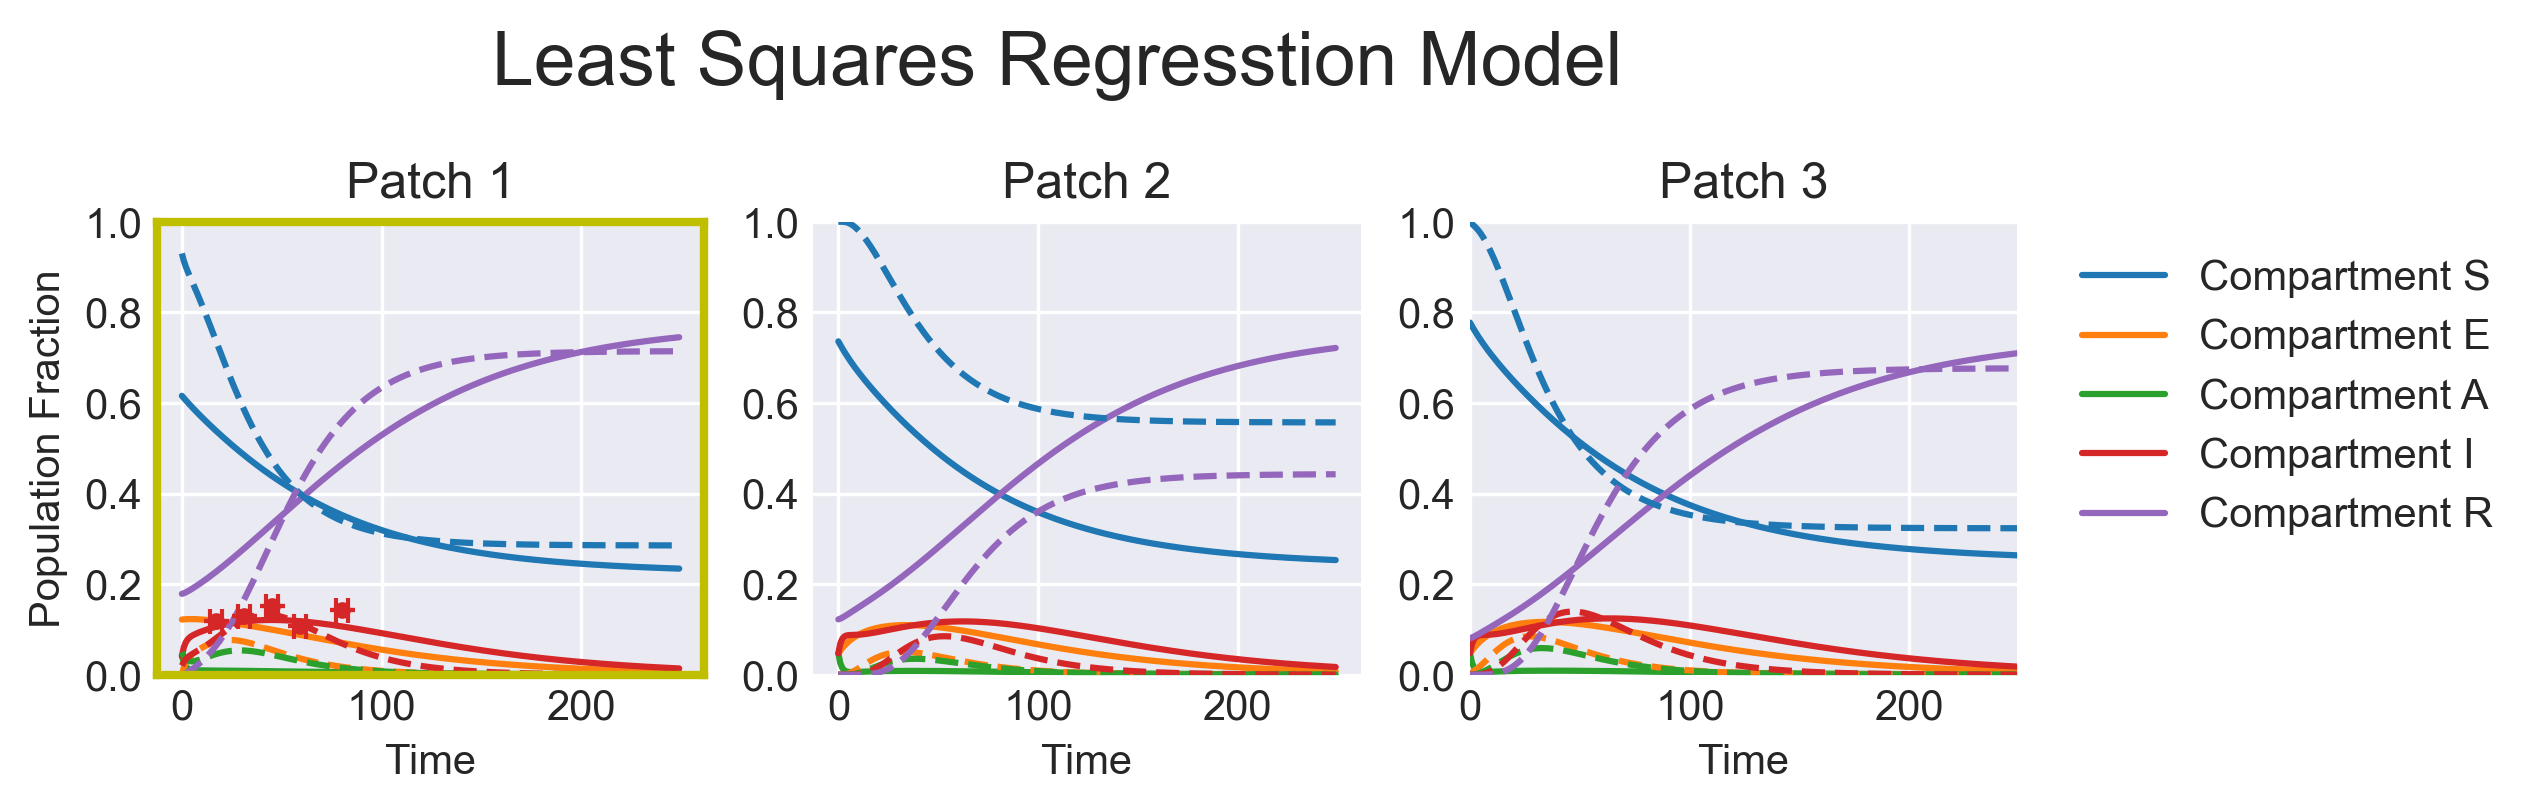

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regresstion Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
#     axs[i].plot(regressed_traj[0,:,i,:])
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Hyper-biasing

In [27]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R_norm , tmat, name='unbiased_model', hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.SGD(1))
# fit_param_model.compile(tf.optimizers.Adam(0.1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')

In [28]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)

Epoch 1/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 2/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 3/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 4/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 5/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 8/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 9/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1589
Epoch 10/1000
128/128 [=====

128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1581
Epoch 71/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1581
Epoch 72/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1581
Epoch 73/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1581
Epoch 74/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1581
Epoch 75/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1580
Epoch 76/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1580
Epoch 77/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1580
Epoch 78/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1580
Epoch 79/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1560
Epoch 145/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1560
Epoch 146/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1560
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1559
Epoch 148/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1559
Epoch 149/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1559
Epoch 150/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1558
Epoch 151/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1558
Epoch 152/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1557
Epoch 153/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1531
Epoch 218/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1530
Epoch 219/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1530
Epoch 220/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1529
Epoch 221/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1529
Epoch 222/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1528
Epoch 223/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1528
Epoch 224/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1528
Epoch 225/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1527
Epoch 226/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1494
Epoch 292/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1494
Epoch 293/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1493
Epoch 294/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1493
Epoch 295/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1493
Epoch 296/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1492
Epoch 297/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1492
Epoch 298/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1491
Epoch 299/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1490
Epoch 300/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1455
Epoch 366/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1455
Epoch 367/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1454
Epoch 368/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1454
Epoch 369/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1453
Epoch 370/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1452
Epoch 371/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1452
Epoch 372/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1452
Epoch 373/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1451
Epoch 374/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1416
Epoch 440/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1415
Epoch 441/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1414
Epoch 442/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1415
Epoch 443/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1413
Epoch 444/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1413
Epoch 445/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1412
Epoch 446/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1411
Epoch 447/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1411
Epoch 448/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1376
Epoch 514/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1377
Epoch 515/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1376
Epoch 516/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1375
Epoch 517/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1374
Epoch 518/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1374
Epoch 519/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1372
Epoch 520/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1372
Epoch 521/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1372
Epoch 522/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1338
Epoch 588/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1337
Epoch 589/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1336
Epoch 590/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1336
Epoch 591/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1337
Epoch 592/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1337
Epoch 593/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1335
Epoch 594/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1335
Epoch 595/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1334
Epoch 596/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1301
Epoch 662/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1302
Epoch 663/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1302
Epoch 664/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1299
Epoch 665/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1300
Epoch 666/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1300
Epoch 667/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1298
Epoch 668/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1299
Epoch 669/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1298
Epoch 670/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1269
Epoch 736/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1269
Epoch 737/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1268
Epoch 738/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1267
Epoch 739/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1268
Epoch 740/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1267
Epoch 741/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1265
Epoch 742/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1265
Epoch 743/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1265
Epoch 744/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1239
Epoch 810/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1237
Epoch 811/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1236
Epoch 812/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1237
Epoch 813/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1237
Epoch 814/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1235
Epoch 815/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1236
Epoch 816/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1235
Epoch 817/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1235
Epoch 818/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1209
Epoch 884/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1209
Epoch 885/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1207
Epoch 886/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1209
Epoch 887/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1209
Epoch 888/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1207
Epoch 889/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1208
Epoch 890/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1207
Epoch 891/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1206
Epoch 892/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1182
Epoch 958/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1185
Epoch 959/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1182
Epoch 960/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1184
Epoch 961/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1182
Epoch 962/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1182
Epoch 963/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1182
Epoch 964/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1182
Epoch 965/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1182
Epoch 966/1000
128/128 [=

In [29]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)

Epoch 1/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1470
Epoch 2/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.1111
Epoch 3/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.0925
Epoch 4/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.0861
Epoch 5/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.0785
Epoch 6/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.0739
Epoch 7/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.0632
Epoch 8/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.0570
Epoch 9/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.0528
Epoch 10/200
128/128 [===============

128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6382
Epoch 71/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6388
Epoch 72/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6386
Epoch 73/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6251
Epoch 74/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6319
Epoch 75/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6216
Epoch 76/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6260
Epoch 77/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6240
Epoch 78/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6182
Epoch 79/200
128/128 [===================

128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5005
Epoch 146/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.4936
Epoch 147/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5015
Epoch 148/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4932
Epoch 149/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4970
Epoch 150/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4940
Epoch 151/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4925
Epoch 152/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.4930
Epoch 153/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4867
Epoch 154/200
128/128 [==========

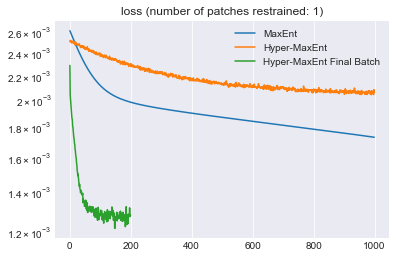

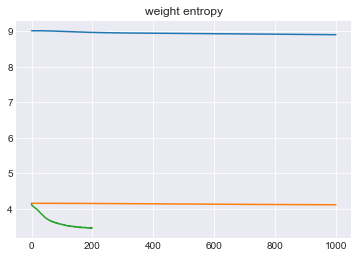

In [30]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
# plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

# plt.plot(hme_history.history['prior-loss'])
# plt.title('neg log-likelihood')
# plt.show()

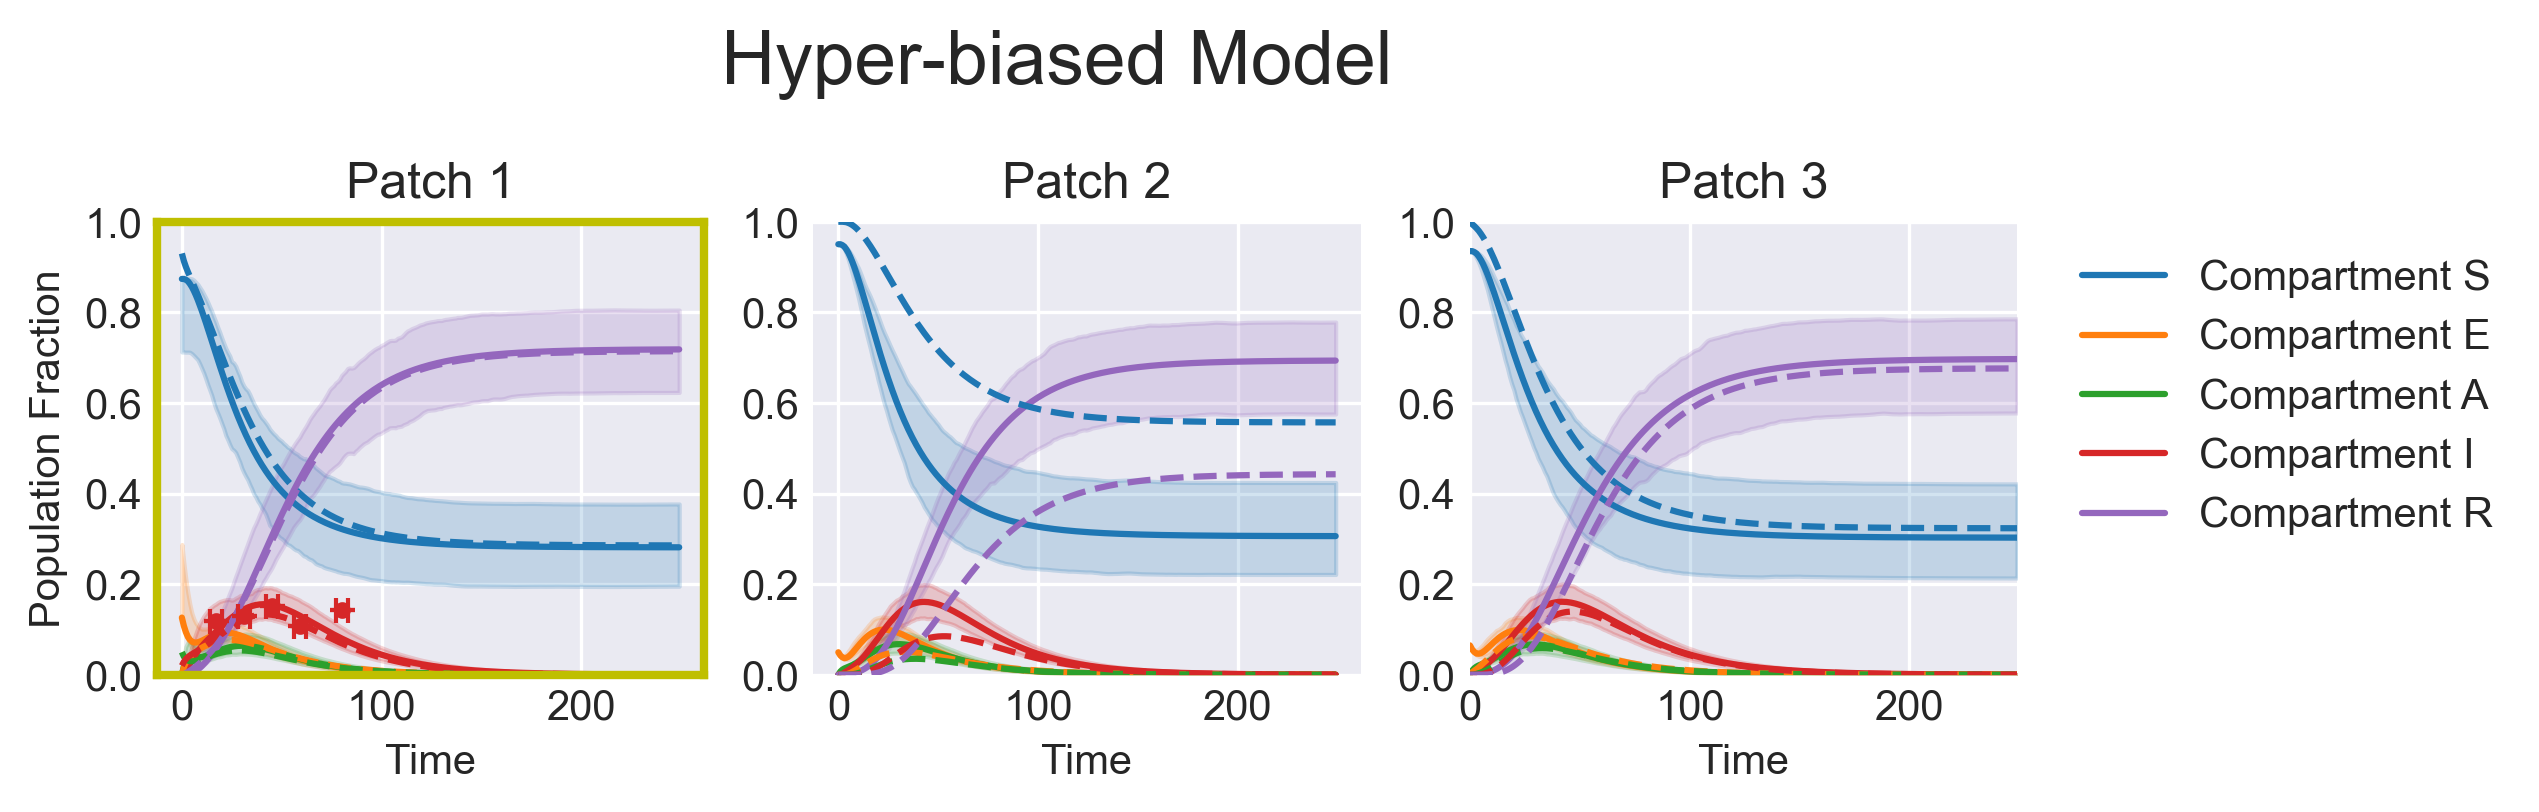

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Hyper-biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

(3, 250, 3, 5)


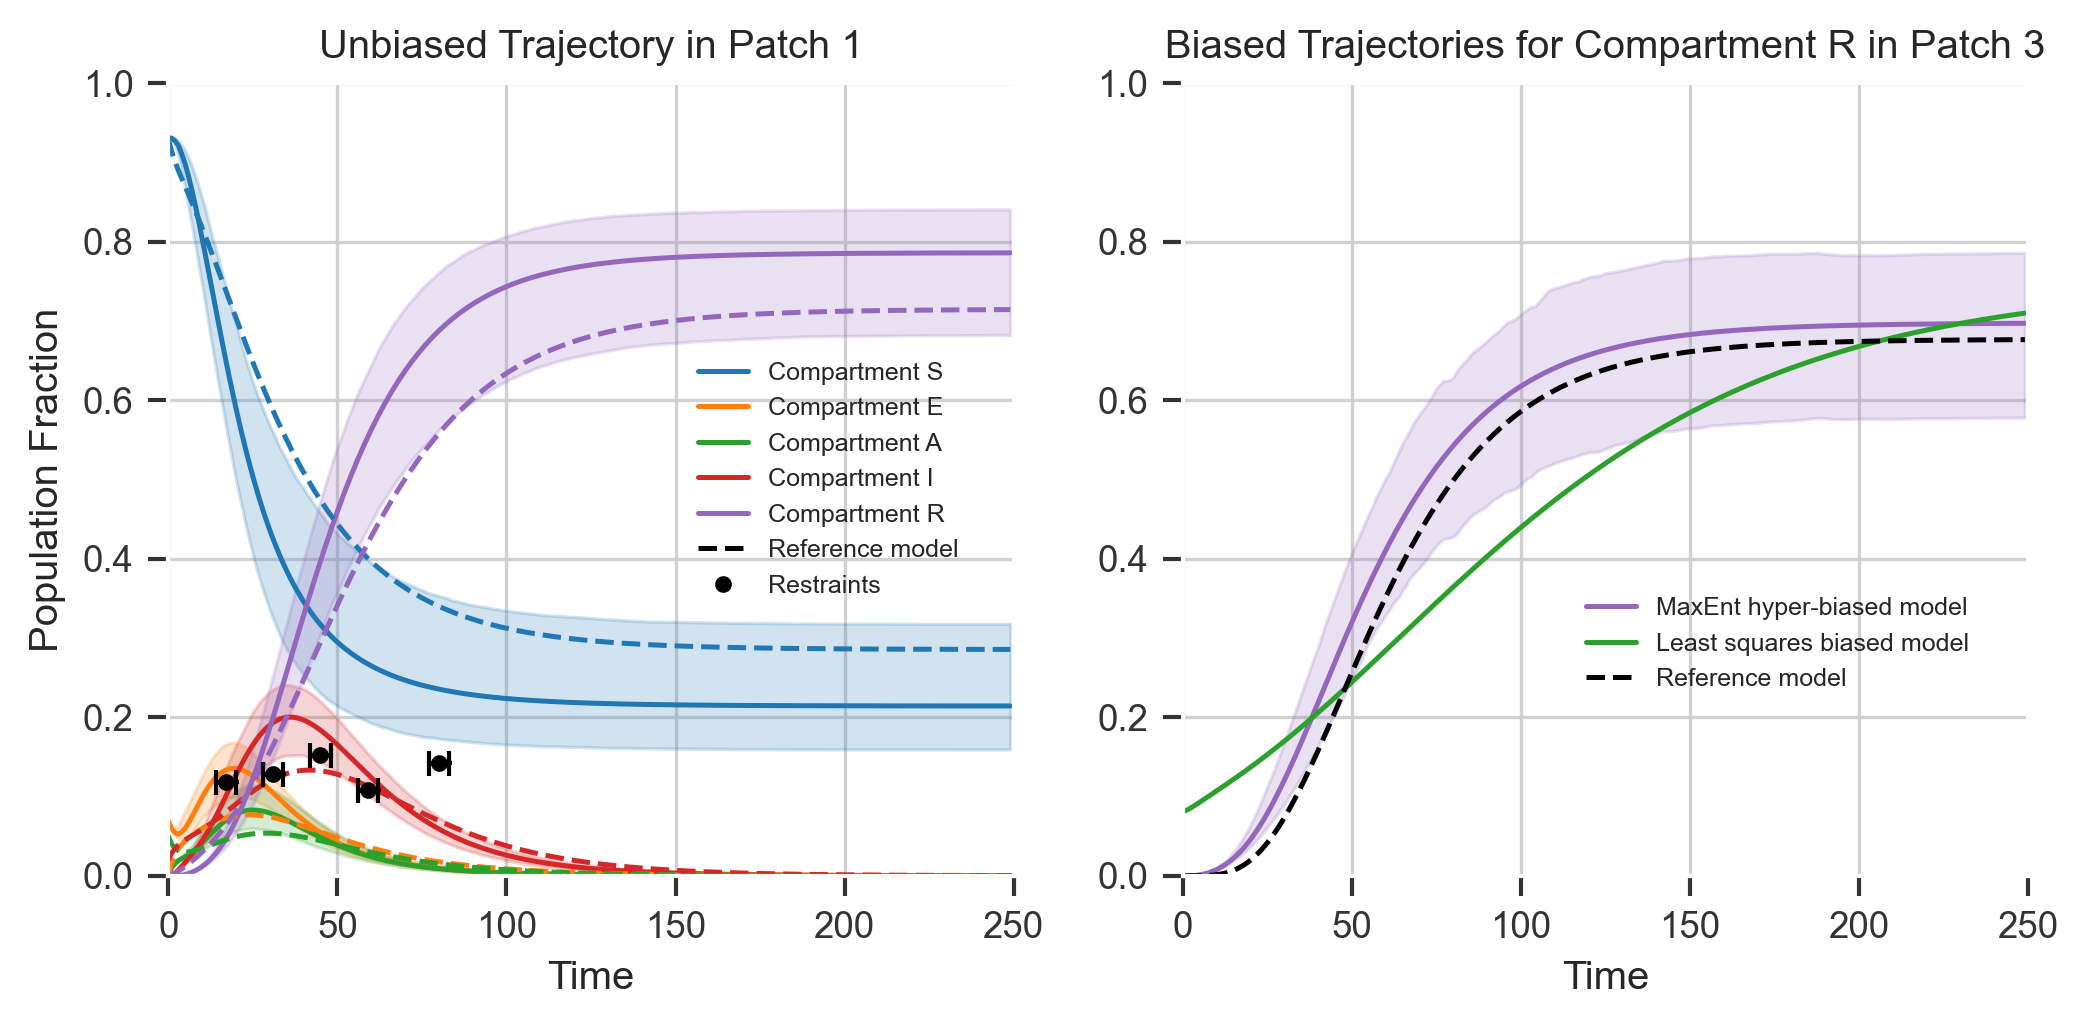

In [32]:
plt.rc('axes', titlesize=8)

import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), dpi =300)

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'Unbiased Trajectory in Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(0.6,0.5), fontsize=6)


plt.setp(axs[1], xlabel='Time', title = 'Biased Trajectories for Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_hyperbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_hyperbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_hyperbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[1, :, :] = mtrajs_hyperbiased
print(qtrajs_hyperbiased.shape)
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= 'C4',  label='MaxEnt hyper-biased model')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='C4', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= 'C2',  label='Least squares biased model')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Reference model')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
plt.savefig('neurips.png', transparent=False, dpi = 300)


In [33]:
print (restraints)
print(hme_model.trajs.shape)

[<maxentep.maxent.Restraint object at 0x0000022CCB24F888>, <maxentep.maxent.Restraint object at 0x0000022CCB24F708>, <maxentep.maxent.Restraint object at 0x0000022CCB24FA48>, <maxentep.maxent.Restraint object at 0x0000022CCB24FB08>, <maxentep.maxent.Restraint object at 0x0000022CCB24FC08>]
(8192, 250, 3, 5)


In [34]:
LS_sample_trajs = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
HyperMaxEnt_sample_trajs = np.empty_like(LS_sample_trajs)
for i in range(npoints):
    sampled_restraints = [n for n in restraints if n != restraints[i]]
    def new_agreement(traj, rs=sampled_restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel_sampled = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, new_agreement)
    rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj_sampled = rmodel_sampled.get_traj()
    rmodel_sampled.fit(timesteps)
    regressed_traj_sampled = rmodel_sampled.get_traj()
    LS_sample_trajs[i,:,:,:] = regressed_traj_sampled
    
    hme_model_sample = maxentep.HyperMaxentModel(sampled_restraints, fit_param_model, model, reweight=False)
    hme_model_sample.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')
    hme_history_sample = hme_model_sample.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)
    hme_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
    # hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
    hme_final_history_sample = hme_model_sample.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)
    HyperMaxEnt_sample_trajs[i,:,:,:] = np.sum(hme_model_sample.trajs * hme_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)

250/250 [==============================] - 44s 174ms/step - loss: 0.0015 - output_2_loss: 0.0015
Epoch 1/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 2/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 3/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 4/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 5/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 8/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 9/1000
128/128 [=================

128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1581
Epoch 70/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1581
Epoch 71/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1581
Epoch 72/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1581
Epoch 73/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1580
Epoch 74/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1580
Epoch 75/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1580
Epoch 76/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1580
Epoch 77/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.1579
Epoch 78/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1559
Epoch 144/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1558
Epoch 145/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1558
Epoch 146/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1558
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1557
Epoch 148/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1557
Epoch 149/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1557
Epoch 150/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1556
Epoch 151/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1556
Epoch 152/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1527
Epoch 218/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1526
Epoch 219/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1526
Epoch 220/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1525
Epoch 221/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1524
Epoch 222/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1524
Epoch 223/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 4.1523
Epoch 224/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1523
Epoch 225/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1523
Epoch 226/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1488
Epoch 292/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1488
Epoch 293/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1487
Epoch 294/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1486
Epoch 295/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1486
Epoch 296/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1485
Epoch 297/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1484
Epoch 298/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1484
Epoch 299/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1483
Epoch 300/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1446
Epoch 366/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1445
Epoch 367/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1444
Epoch 368/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1444
Epoch 369/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1444
Epoch 370/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1444
Epoch 371/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1442
Epoch 372/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1442
Epoch 373/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1441
Epoch 374/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1403
Epoch 440/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1402
Epoch 441/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1402
Epoch 442/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1401
Epoch 443/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1400
Epoch 444/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1399
Epoch 445/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1399
Epoch 446/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1398
Epoch 447/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1398
Epoch 448/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1360
Epoch 514/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1360
Epoch 515/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1357
Epoch 516/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1357
Epoch 517/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1358
Epoch 518/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1356
Epoch 519/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1356
Epoch 520/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1356
Epoch 521/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1355
Epoch 522/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1318
Epoch 588/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1317
Epoch 589/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1317
Epoch 590/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1317
Epoch 591/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1316
Epoch 592/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1317
Epoch 593/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1315
Epoch 594/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1315
Epoch 595/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1314
Epoch 596/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1279
Epoch 662/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1278
Epoch 663/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1278
Epoch 664/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1276
Epoch 665/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1276
Epoch 666/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1276
Epoch 667/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1275
Epoch 668/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1275
Epoch 669/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1274
Epoch 670/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1241
Epoch 736/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1241
Epoch 737/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1241
Epoch 738/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1241
Epoch 739/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1240
Epoch 740/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1239
Epoch 741/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1239
Epoch 742/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1239
Epoch 743/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1238
Epoch 744/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1206
Epoch 810/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1207
Epoch 811/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1207
Epoch 812/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1206
Epoch 813/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1206
Epoch 814/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1205
Epoch 815/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1206
Epoch 816/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1203
Epoch 817/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1204
Epoch 818/1000
128/128 [=

128/128 [==============================] - ETA: 0s - loss: 0.0026 - weight-entropy: 4.11 - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1177
Epoch 884/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1174
Epoch 885/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1175
Epoch 886/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0026 - weight-entropy: 4.1177
Epoch 887/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1175: 0s - loss: 0.0025 - weight-entropy: 
Epoch 888/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1173
Epoch 889/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1173
Epoch 890/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1174
Epoch 891/1000
128/128 [=========================

128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1147
Epoch 957/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1148
Epoch 958/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1148
Epoch 959/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1146
Epoch 960/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1146
Epoch 961/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1147
Epoch 962/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1146
Epoch 963/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1145
Epoch 964/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1144
Epoch 965/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.8345
Epoch 26/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.8193
Epoch 27/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.8024
Epoch 28/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.7846
Epoch 29/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.7657
Epoch 30/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.7512
Epoch 31/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.7303
Epoch 32/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.7276
Epoch 33/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.7152
Epoch 34/200
128/128 [===================

Epoch 101/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.2238
Epoch 102/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.2297
Epoch 103/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.2226
Epoch 104/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.2151
Epoch 105/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.2157
Epoch 106/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.2175
Epoch 107/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.1930
Epoch 108/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.2286
Epoch 109/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.2041
Epoch 110/200
128/1

128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.1250
Epoch 177/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.0847
Epoch 178/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.1031
Epoch 179/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.1169
Epoch 180/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.1027
Epoch 181/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.0820
Epoch 182/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.0844
Epoch 183/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.1004
Epoch 184/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.1036
Epoch 185/200
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1588
Epoch 44/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1588
Epoch 45/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1588
Epoch 46/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1588
Epoch 47/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1588
Epoch 48/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1588
Epoch 49/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1588
Epoch 50/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1587
Epoch 51/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1587
Epoch 52/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1582
Epoch 119/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1581
Epoch 120/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1581
Epoch 121/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1581
Epoch 122/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1581
Epoch 123/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1581
Epoch 124/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1581
Epoch 125/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1581
Epoch 126/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 4.1581
Epoch 127/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1571
Epoch 193/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1571
Epoch 194/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1570
Epoch 195/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 4.1570
Epoch 196/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1570
Epoch 197/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1570
Epoch 198/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1570
Epoch 199/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1570
Epoch 200/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1569
Epoch 201/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1556
Epoch 267/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1556
Epoch 268/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1556
Epoch 269/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1556
Epoch 270/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1555
Epoch 271/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1555
Epoch 272/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1555
Epoch 273/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1555
Epoch 274/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1555
Epoch 275/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1539
Epoch 341/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1539
Epoch 342/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1539
Epoch 343/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1538
Epoch 344/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1538
Epoch 345/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1538
Epoch 346/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1537
Epoch 347/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1537
Epoch 348/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1537
Epoch 349/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1519
Epoch 415/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1519
Epoch 416/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1519
Epoch 417/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1518
Epoch 418/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1518
Epoch 419/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1518
Epoch 420/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1518
Epoch 421/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1517
Epoch 422/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1517
Epoch 423/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1499
Epoch 489/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1498
Epoch 490/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1498
Epoch 491/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1498
Epoch 492/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1498
Epoch 493/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1497
Epoch 494/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1497
Epoch 495/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1496
Epoch 496/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1496
Epoch 497/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1476
Epoch 563/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1476
Epoch 564/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1475
Epoch 565/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1475
Epoch 566/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1475
Epoch 567/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1475
Epoch 568/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1474
Epoch 569/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1474
Epoch 570/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1474
Epoch 571/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1453
Epoch 637/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1453
Epoch 638/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1453
Epoch 639/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1453
Epoch 640/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1452
Epoch 641/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1452
Epoch 642/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1451
Epoch 643/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1451
Epoch 644/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1450
Epoch 645/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1430
Epoch 710/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1431
Epoch 711/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1430
Epoch 712/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1430
Epoch 713/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1430
Epoch 714/1000
128/128 [==============================] - ETA: 0s - loss: 0.0026 - weight-entropy: 4.14 - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1429
Epoch 715/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1429
Epoch 716/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1429
Epoch 717/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - 

Epoch 782/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1408
Epoch 783/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1408
Epoch 784/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1408
Epoch 785/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1407
Epoch 786/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1407
Epoch 787/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1407
Epoch 788/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1406
Epoch 789/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1406
Epoch 790/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1405
Epoch 791/

128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1385
Epoch 857/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1384
Epoch 858/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1384
Epoch 859/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1383
Epoch 860/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1384
Epoch 861/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1384
Epoch 862/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1383
Epoch 863/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1383
Epoch 864/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1383
Epoch 865/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1363
Epoch 931/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1363
Epoch 932/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1362
Epoch 933/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1362
Epoch 934/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1362
Epoch 935/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1360
Epoch 936/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1361
Epoch 937/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1360
Epoch 938/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1361
Epoch 939/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1530
Epoch 2/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1329
Epoch 3/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1130
Epoch 4/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1025
Epoch 5/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.0919
Epoch 6/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.0806
Epoch 7/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.0716
Epoch 8/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.0636
Epoch 9/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.0546
Epoch 10/200
128/128 [===========================

Epoch 74/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.5397
Epoch 75/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.5292
Epoch 76/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.5172
Epoch 77/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.5286
Epoch 78/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.5256
Epoch 79/200
128/128 [==============================] - ETA: 0s - loss: 0.0015 - weight-entropy: 3.51 - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.5175
Epoch 80/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.5171
Epoch 81/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.5171
Epoch 82/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - wei

Epoch 149/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.3970
Epoch 150/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.3851
Epoch 151/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.3851
Epoch 152/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.3897
Epoch 153/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.3860
Epoch 154/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.3992
Epoch 155/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.3794
Epoch 156/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.3933
Epoch 157/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.3987
Epoch 158/200
128/1

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 18/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 19/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 20/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 21/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 22/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 23/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 24/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 25/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 26/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589: 0s - loss: 0.0021 - weight-entropy: 4.
Epoch 92/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1589
Epoch 93/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 94/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 95/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 96/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 97/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1589
Epoch 98/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1589
Epoch 99/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1588
Epoch 165/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1588
Epoch 166/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1588
Epoch 167/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1588
Epoch 168/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1588
Epoch 169/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1588
Epoch 170/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1588
Epoch 171/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1588
Epoch 172/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1588
Epoch 173/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 238/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 239/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1587
Epoch 240/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 241/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 242/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1587
Epoch 243/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 244/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1587
Epoch 245/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1587
Epoch 246/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1586: 0s - loss: 0.0021 - weight-entropy: 4.
Epoch 311/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1586
Epoch 312/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1586
Epoch 313/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1586
Epoch 314/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1586
Epoch 315/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1586
Epoch 316/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1586
Epoch 317/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1586
Epoch 318/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-e

128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1585
Epoch 384/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1585
Epoch 385/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1585
Epoch 386/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1585
Epoch 387/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1585
Epoch 388/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1585
Epoch 389/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1585
Epoch 390/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1585
Epoch 391/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1585
Epoch 392/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1584
Epoch 457/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1584
Epoch 458/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1584
Epoch 459/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1584
Epoch 460/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1584
Epoch 461/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1584
Epoch 462/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1584
Epoch 463/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1584
Epoch 464/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1584
Epoch 465/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 531/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 532/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 533/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 534/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 535/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 536/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1582
Epoch 537/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 538/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1582
Epoch 539/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 605/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 606/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 607/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 608/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 609/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 610/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 611/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 612/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1581
Epoch 613/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 679/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 680/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 681/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 682/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 683/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 684/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 685/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 686/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1579
Epoch 687/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 752/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 753/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 754/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 755/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 756/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 757/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 758/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 759/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1577
Epoch 760/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 826/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 827/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 828/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 829/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 830/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 831/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 832/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 833/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1576
Epoch 834/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 900/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 901/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 902/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 903/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 904/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 905/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 906/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 907/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1574
Epoch 908/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 974/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 975/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 976/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 977/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 978/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 979/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 980/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 981/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1572
Epoch 982/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.8638
Epoch 43/200
128/128 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 3.8584
Epoch 44/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.8528
Epoch 45/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.8435
Epoch 46/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.8368
Epoch 47/200
128/128 [==============================] - 0s 3ms/step - loss: 0.0015 - weight-entropy: 3.8300
Epoch 48/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.8244
Epoch 49/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.8159
Epoch 50/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.8096
Epoch 51/200
128/128 [===================

128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.6089
Epoch 118/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.6116
Epoch 119/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.6124
Epoch 120/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.6099
Epoch 121/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.6122
Epoch 122/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5957
Epoch 123/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5959
Epoch 124/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.6018
Epoch 125/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5979
Epoch 126/200
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.5442
Epoch 193/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.5410
Epoch 194/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5315
Epoch 195/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5297
Epoch 196/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5346
Epoch 197/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5364
Epoch 198/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5296
Epoch 199/200
128/128 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 3.5265
Epoch 200/200
250/250 [==============================] - 52s 209ms/step - loss: 9.3580e-04 - output_2_loss: 9.3580e-04
Epoch 1/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.1578
Epoch 60/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.1577
Epoch 61/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1577
Epoch 62/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.1576
Epoch 63/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1576
Epoch 64/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 4.1576
Epoch 65/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.1575
Epoch 66/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1575
Epoch 67/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.1574
Epoch 68/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1537
Epoch 134/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1537
Epoch 135/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1536
Epoch 136/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1535
Epoch 137/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1535
Epoch 138/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1534
Epoch 139/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1533
Epoch 140/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1532
Epoch 141/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.1532
Epoch 142/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 9.5437e-04 - weight-entropy: 4.1481
Epoch 206/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.5745e-04 - weight-entropy: 4.1480
Epoch 207/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.4718e-04 - weight-entropy: 4.1479
Epoch 208/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.3424e-04 - weight-entropy: 4.1478
Epoch 209/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.2041e-04 - weight-entropy: 4.1476
Epoch 210/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.2702e-04 - weight-entropy: 4.1476
Epoch 211/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.3919e-04 - weight-entropy: 4.1475
Epoch 212/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.3163e-04 - weight-entropy: 4.1474
Epoch 213/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.1685e-04 - weight-entro

128/128 [==============================] - 0s 1ms/step - loss: 8.4362e-04 - weight-entropy: 4.1414
Epoch 277/1000
128/128 [==============================] - 0s 1ms/step - loss: 8.6391e-04 - weight-entropy: 4.1414
Epoch 278/1000
128/128 [==============================] - 0s 1ms/step - loss: 8.3535e-04 - weight-entropy: 4.1412
Epoch 279/1000
128/128 [==============================] - 0s 2ms/step - loss: 8.4288e-04 - weight-entropy: 4.1411
Epoch 280/1000
128/128 [==============================] - 0s 1ms/step - loss: 8.5987e-04 - weight-entropy: 4.1411
Epoch 281/1000
128/128 [==============================] - 0s 1ms/step - loss: 8.4207e-04 - weight-entropy: 4.1410
Epoch 282/1000
128/128 [==============================] - 0s 1ms/step - loss: 8.3112e-04 - weight-entropy: 4.1408
Epoch 283/1000
128/128 [==============================] - 0s 1ms/step - loss: 8.3181e-04 - weight-entropy: 4.1407
Epoch 284/1000
128/128 [==============================] - 0s 1ms/step - loss: 8.5010e-04 - weight-entro

Epoch 348/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.5933e-04 - weight-entropy: 4.1342
Epoch 349/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.9573e-04 - weight-entropy: 4.1343
Epoch 350/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.7307e-04 - weight-entropy: 4.1341
Epoch 351/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.5887e-04 - weight-entropy: 4.1339
Epoch 352/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.6309e-04 - weight-entropy: 4.1339
Epoch 353/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.8429e-04 - weight-entropy: 4.1339
Epoch 354/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.5286e-04 - weight-entropy: 4.1336
Epoch 355/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.6584e-04 - weight-entropy: 4.1336
Epoch 356/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.7824e-04

128/128 [==============================] - 0s 1ms/step - loss: 6.9530e-04 - weight-entropy: 4.1271
Epoch 420/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.1129e-04 - weight-entropy: 4.1271
Epoch 421/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.0412e-04 - weight-entropy: 4.1269
Epoch 422/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.0725e-04 - weight-entropy: 4.1269
Epoch 423/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.1449e-04 - weight-entropy: 4.1268
Epoch 424/1000
128/128 [==============================] - 0s 2ms/step - loss: 7.0460e-04 - weight-entropy: 4.1267
Epoch 425/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.0883e-04 - weight-entropy: 4.1266
Epoch 426/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.0706e-04 - weight-entropy: 4.1265
Epoch 427/1000
128/128 [==============================] - 0s 1ms/step - loss: 7.1852e-04 - weight-entro

Epoch 491/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.4983e-04 - weight-entropy: 4.1201
Epoch 492/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.4860e-04 - weight-entropy: 4.1200
Epoch 493/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.7718e-04 - weight-entropy: 4.1201
Epoch 494/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.6765e-04 - weight-entropy: 4.1200
Epoch 495/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.8102e-04 - weight-entropy: 4.1199
Epoch 496/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.5248e-04 - weight-entropy: 4.1196
Epoch 497/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.5875e-04 - weight-entropy: 4.1196
Epoch 498/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.7188e-04 - weight-entropy: 4.1196
Epoch 499/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.6794e-04

128/128 [==============================] - 0s 1ms/step - loss: 6.3266e-04 - weight-entropy: 4.1137
Epoch 563/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.2465e-04 - weight-entropy: 4.1135
Epoch 564/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.2980e-04 - weight-entropy: 4.1134
Epoch 565/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.2806e-04 - weight-entropy: 4.1133
Epoch 566/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.3192e-04 - weight-entropy: 4.1133
Epoch 567/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.3248e-04 - weight-entropy: 4.1132
Epoch 568/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.1254e-04 - weight-entropy: 4.1129
Epoch 569/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.1646e-04 - weight-entropy: 4.1129
Epoch 570/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.4659e-04 - weight-entro

Epoch 634/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.1501e-04 - weight-entropy: 4.1076
Epoch 635/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.2056e-04 - weight-entropy: 4.1076
Epoch 636/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.8784e-04 - weight-entropy: 4.1071
Epoch 637/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.1175e-04 - weight-entropy: 4.1074
Epoch 638/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.1331e-04 - weight-entropy: 4.1073
Epoch 639/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.1349e-04 - weight-entropy: 4.1072
Epoch 640/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.2881e-04 - weight-entropy: 4.1073
Epoch 641/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.1664e-04 - weight-entropy: 4.1071
Epoch 642/1000
128/128 [==============================] - 0s 1ms/step - loss: 6.1307e-04

128/128 [==============================] - 0s 1ms/step - loss: 5.8564e-04 - weight-entropy: 4.1019
Epoch 706/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.9571e-04 - weight-entropy: 4.1020
Epoch 707/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.8616e-04 - weight-entropy: 4.1018
Epoch 708/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.9163e-04 - weight-entropy: 4.1019
Epoch 709/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.1296e-04 - weight-entropy: 4.1019
Epoch 710/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.7030e-04 - weight-entropy: 4.1015
Epoch 711/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.8726e-04 - weight-entropy: 4.1015
Epoch 712/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.8403e-04 - weight-entropy: 4.1014
Epoch 713/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.6994e-04 - weight-entro

Epoch 777/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.6783e-04 - weight-entropy: 4.0968
Epoch 778/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.8643e-04 - weight-entropy: 4.0969
Epoch 779/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.7770e-04 - weight-entropy: 4.0968
Epoch 780/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.8561e-04 - weight-entropy: 4.0968
Epoch 781/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.5696e-04 - weight-entropy: 4.0964
Epoch 782/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.8324e-04 - weight-entropy: 4.0967
Epoch 783/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.6350e-04 - weight-entropy: 4.0963
Epoch 784/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.9995e-04 - weight-entropy: 4.0967
Epoch 785/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.6476e-04

128/128 [==============================] - 0s 2ms/step - loss: 5.3232e-04 - weight-entropy: 4.0920
Epoch 848/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.8004e-04 - weight-entropy: 4.0926
Epoch 849/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.6973e-04 - weight-entropy: 4.0923
Epoch 850/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.5200e-04 - weight-entropy: 4.0920
Epoch 851/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.8959e-04 - weight-entropy: 4.0925
Epoch 852/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.4315e-04 - weight-entropy: 4.0918
Epoch 853/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.5936e-04 - weight-entropy: 4.0920
Epoch 854/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.5071e-04 - weight-entropy: 4.0918
Epoch 855/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.5996e-04 - weight-entro

128/128 [==============================] - 0s 1ms/step - loss: 5.7778e-04 - weight-entropy: 4.0887
Epoch 919/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.3787e-04 - weight-entropy: 4.0880
Epoch 920/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.6215e-04 - weight-entropy: 4.0882
Epoch 921/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.5590e-04 - weight-entropy: 4.0881
Epoch 922/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.3478e-04 - weight-entropy: 4.0878
Epoch 923/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.3893e-04 - weight-entropy: 4.0878
Epoch 924/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.3989e-04 - weight-entropy: 4.0878
Epoch 925/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.4388e-04 - weight-entropy: 4.0878
Epoch 926/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.7603e-04 - weight-entro

128/128 [==============================] - 0s 1ms/step - loss: 5.3129e-04 - weight-entropy: 4.0843
Epoch 990/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.1055e-04 - weight-entropy: 4.0841
Epoch 991/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.5158e-04 - weight-entropy: 4.0847
Epoch 992/1000
128/128 [==============================] - 0s 3ms/step - loss: 5.2375e-04 - weight-entropy: 4.0841
Epoch 993/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.4910e-04 - weight-entropy: 4.0845
Epoch 994/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.2233e-04 - weight-entropy: 4.0840
Epoch 995/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.4393e-04 - weight-entropy: 4.0844
Epoch 996/1000
128/128 [==============================] - 0s 2ms/step - loss: 5.4477e-04 - weight-entropy: 4.0843
Epoch 997/1000
128/128 [==============================] - 0s 1ms/step - loss: 5.3300e-04 - weight-entro

128/128 [==============================] - 0s 1ms/step - loss: 4.0200e-04 - weight-entropy: 4.0041
Epoch 56/200
128/128 [==============================] - 0s 1ms/step - loss: 3.9891e-04 - weight-entropy: 4.0050
Epoch 57/200
128/128 [==============================] - 0s 1ms/step - loss: 3.7424e-04 - weight-entropy: 4.0049
Epoch 58/200
128/128 [==============================] - 0s 2ms/step - loss: 3.9029e-04 - weight-entropy: 4.0006
Epoch 59/200
128/128 [==============================] - 0s 1ms/step - loss: 3.7488e-04 - weight-entropy: 3.9993
Epoch 60/200
128/128 [==============================] - 0s 1ms/step - loss: 3.6585e-04 - weight-entropy: 4.0027
Epoch 61/200
128/128 [==============================] - 0s 1ms/step - loss: 3.8851e-04 - weight-entropy: 4.0013
Epoch 62/200
128/128 [==============================] - 0s 1ms/step - loss: 4.0000e-04 - weight-entropy: 4.0000
Epoch 63/200
128/128 [==============================] - 0s 1ms/step - loss: 3.7617e-04 - weight-entropy: 4.0004
Epoch

128/128 [==============================] - 0s 2ms/step - loss: 3.3787e-04 - weight-entropy: 3.9557
Epoch 129/200
128/128 [==============================] - 0s 2ms/step - loss: 3.1603e-04 - weight-entropy: 3.9521
Epoch 130/200
128/128 [==============================] - 0s 2ms/step - loss: 3.1989e-04 - weight-entropy: 3.9553
Epoch 131/200
128/128 [==============================] - 0s 1ms/step - loss: 3.3488e-04 - weight-entropy: 3.9508
Epoch 132/200
128/128 [==============================] - 0s 1ms/step - loss: 3.2246e-04 - weight-entropy: 3.9525
Epoch 133/200
128/128 [==============================] - 0s 2ms/step - loss: 3.0601e-04 - weight-entropy: 3.9505
Epoch 134/200
128/128 [==============================] - 0s 1ms/step - loss: 3.4333e-04 - weight-entropy: 3.9498
Epoch 135/200
128/128 [==============================] - 0s 2ms/step - loss: 3.2018e-04 - weight-entropy: 3.9506
Epoch 136/200
128/128 [==============================] - 0s 2ms/step - loss: 3.2875e-04 - weight-entropy: 3.94

250/250 [==============================] - 51s 206ms/step - loss: 0.0029 - output_2_loss: 0.0029
Epoch 1/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 2/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 3/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 4/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 5/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 8/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.1589
Epoch 9/1000
128/128 [=================

128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1579
Epoch 68/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1578
Epoch 69/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1578
Epoch 70/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1578
Epoch 71/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1577
Epoch 72/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1577
Epoch 73/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.1577
Epoch 74/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1576
Epoch 75/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.1576
Epoch 76/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1548
Epoch 141/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1548
Epoch 142/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1547
Epoch 143/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1546
Epoch 144/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1546
Epoch 145/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 4.1545
Epoch 146/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1545
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1544
Epoch 148/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 4.1544
Epoch 149/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1503
Epoch 215/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1503
Epoch 216/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1502
Epoch 217/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1501
Epoch 218/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1501
Epoch 219/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1500
Epoch 220/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 4.1500
Epoch 221/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1499
Epoch 222/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.1498
Epoch 223/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1450
Epoch 289/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1449
Epoch 290/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1448
Epoch 291/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1448
Epoch 292/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1447
Epoch 293/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1446
Epoch 294/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1445
Epoch 295/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 4.1444
Epoch 296/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1444
Epoch 297/1000
128/128 [=

128/128 [==============================] - 0s 3ms/step - loss: 0.0025 - weight-entropy: 4.1393
Epoch 363/1000
128/128 [==============================] - 0s 3ms/step - loss: 0.0025 - weight-entropy: 4.1392
Epoch 364/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1391
Epoch 365/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1390
Epoch 366/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1390
Epoch 367/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1389
Epoch 368/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1388
Epoch 369/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1387
Epoch 370/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1386
Epoch 371/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1333
Epoch 437/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1333
Epoch 438/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1332
Epoch 439/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1331
Epoch 440/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1330
Epoch 441/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1329
Epoch 442/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1328
Epoch 443/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1327
Epoch 444/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1327
Epoch 445/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1275
Epoch 511/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1274
Epoch 512/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1274
Epoch 513/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1272
Epoch 514/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1272
Epoch 515/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1271
Epoch 516/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1271
Epoch 517/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1269
Epoch 518/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1269
Epoch 519/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1218
Epoch 585/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1218
Epoch 586/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1216
Epoch 587/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1216
Epoch 588/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1214
Epoch 589/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1215
Epoch 590/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1214
Epoch 591/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1212
Epoch 592/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1212
Epoch 593/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1165
Epoch 659/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1165
Epoch 660/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1164
Epoch 661/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1164
Epoch 662/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1163
Epoch 663/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1160
Epoch 664/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1162
Epoch 665/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1162
Epoch 666/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1159
Epoch 667/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1117
Epoch 732/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1115
Epoch 733/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1114
Epoch 734/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1113
Epoch 735/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1113
Epoch 736/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1113
Epoch 737/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1113
Epoch 738/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1111
Epoch 739/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1110
Epoch 740/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1068
Epoch 806/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1068
Epoch 807/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1067
Epoch 808/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1067
Epoch 809/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1066
Epoch 810/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1065
Epoch 811/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1065
Epoch 812/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1065
Epoch 813/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1065
Epoch 814/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1029
Epoch 880/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1028
Epoch 881/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1025
Epoch 882/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1025
Epoch 883/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1024
Epoch 884/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1024
Epoch 885/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1023
Epoch 886/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1024
Epoch 887/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1021
Epoch 888/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.0986
Epoch 954/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.0988
Epoch 955/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.0985
Epoch 956/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.0987
Epoch 957/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.0986
Epoch 958/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.0984
Epoch 959/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.0988
Epoch 960/1000
128/128 [==============================] - ETA: 0s - loss: 0.0023 - weight-entropy: 4.09 - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.0983
Epoch 961/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - 

128/128 [==============================] - 0s 3ms/step - loss: 0.0013 - weight-entropy: 3.6837
Epoch 22/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6668
Epoch 23/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6526
Epoch 24/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6385
Epoch 25/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6247
Epoch 26/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6150
Epoch 27/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6092
Epoch 28/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.5964
Epoch 29/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5959
Epoch 30/200
128/128 [===================

Epoch 97/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.4748
Epoch 98/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4866
Epoch 99/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4760
Epoch 100/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4822
Epoch 101/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4821
Epoch 102/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4751: 0s - loss: 0.0013 - weight-entropy: 3.
Epoch 103/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.4859
Epoch 104/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4758
Epoch 105/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weigh

128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4678
Epoch 172/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4737
Epoch 173/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4760
Epoch 174/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4716
Epoch 175/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4686
Epoch 176/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4739
Epoch 177/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4632
Epoch 178/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4694
Epoch 179/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4755
Epoch 180/200
128/128 [==========

In [37]:
np.save('HyperMaxEnt_sample_trajs',HyperMaxEnt_sample_trajs)
np.save('LS_sample_trajs',LS_sample_trajs)

0.00035908612428533994
0.009003065086378662


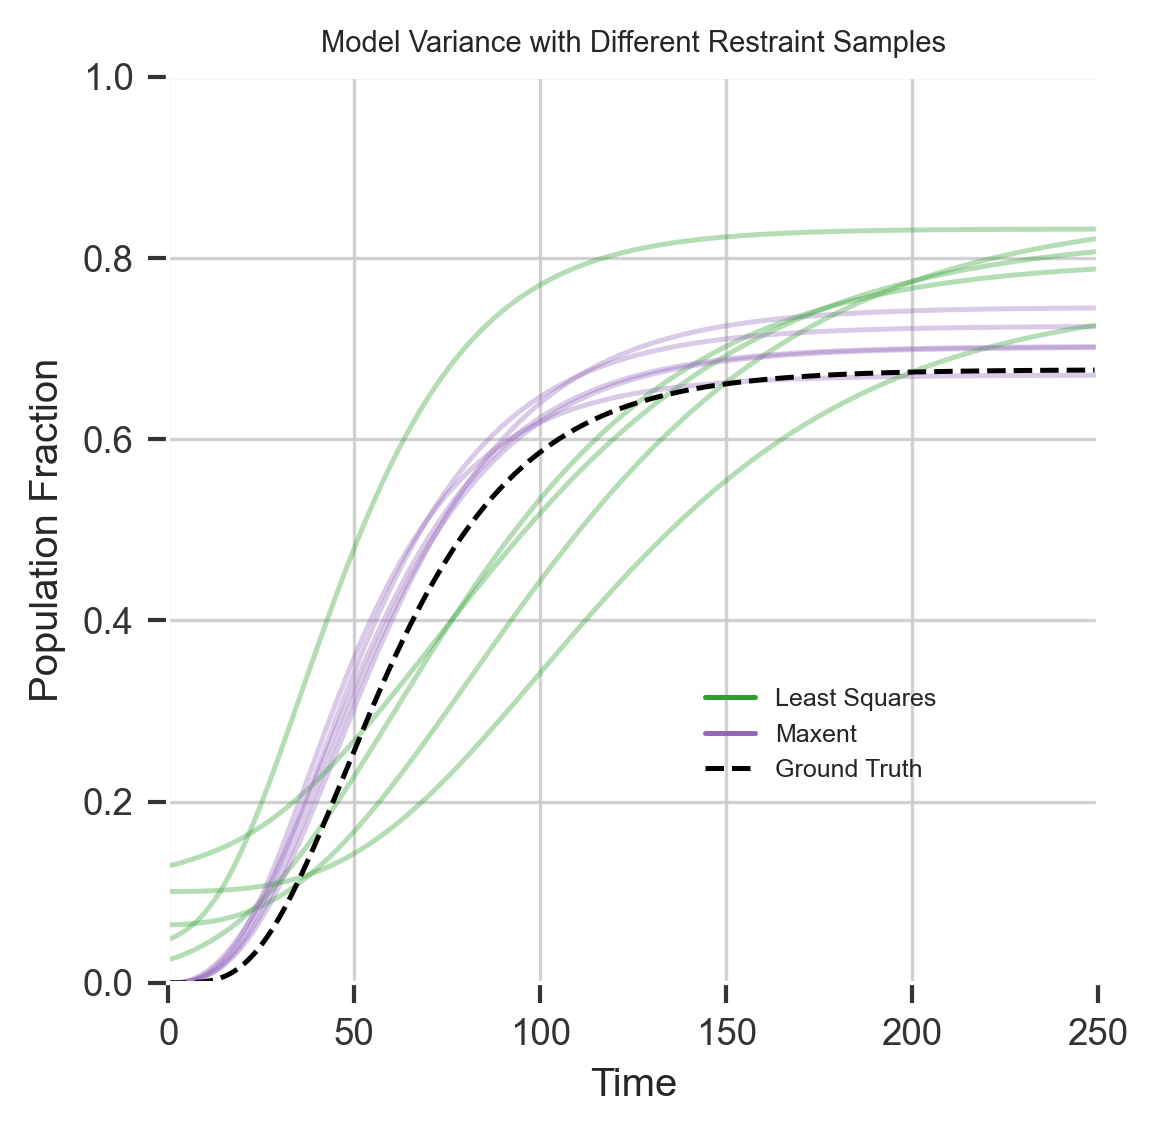

In [48]:
HperMaxEnt_sample_trajs = np.load('HyperMaxEnt_sample_trajs.npy')
LS_sample_trajs = np.load('LS_sample_trajs.npy')
fig, ax = plt.subplots(figsize=(4,4), dpi=300) 
plt.rc('axes', titlesize=7)
plt.setp(plt.gca(), ylabel='Population Fraction' ,xlabel='Time', title = "Model Variance with Different Restraint Samples", xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for i,y in enumerate(LS_sample_trajs):
    plt.plot(x, y[:,2,4], color= 'C2', alpha=0.35)
    plt.plot(x, HyperMaxEnt_sample_trajs[i,:,2,4], color= 'C4', alpha=0.35)
plt.plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Ground Truth')
plt.legend(bbox_to_anchor=(0.65,0.45), fontsize=6)
hand, labl = ax.get_legend_handles_labels()
predicted_label_LS = 'Least Squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='C2')
predicted_label_HM = 'Maxent'
predicted_line_HM = plt.Line2D((0,1),(0,0), color='C4')
plt.legend([predicted_line_LS, predicted_line_HM]+[handle for i,handle in enumerate(hand)],
              [predicted_label_LS, predicted_label_HM]+[label for i,label in enumerate(labl)]
                , bbox_to_anchor=(0.85,0.35), fontsize=6)
plt.savefig('neurips_LS.png', transparent=False, dpi = 300)

print(np.mean(np.var(HyperMaxEnt_sample_trajs[:,:,2,4], axis=0)))
print(np.mean(np.var(LS_sample_trajs[:,:,2,4], axis=0)))


(250, 3, 5)


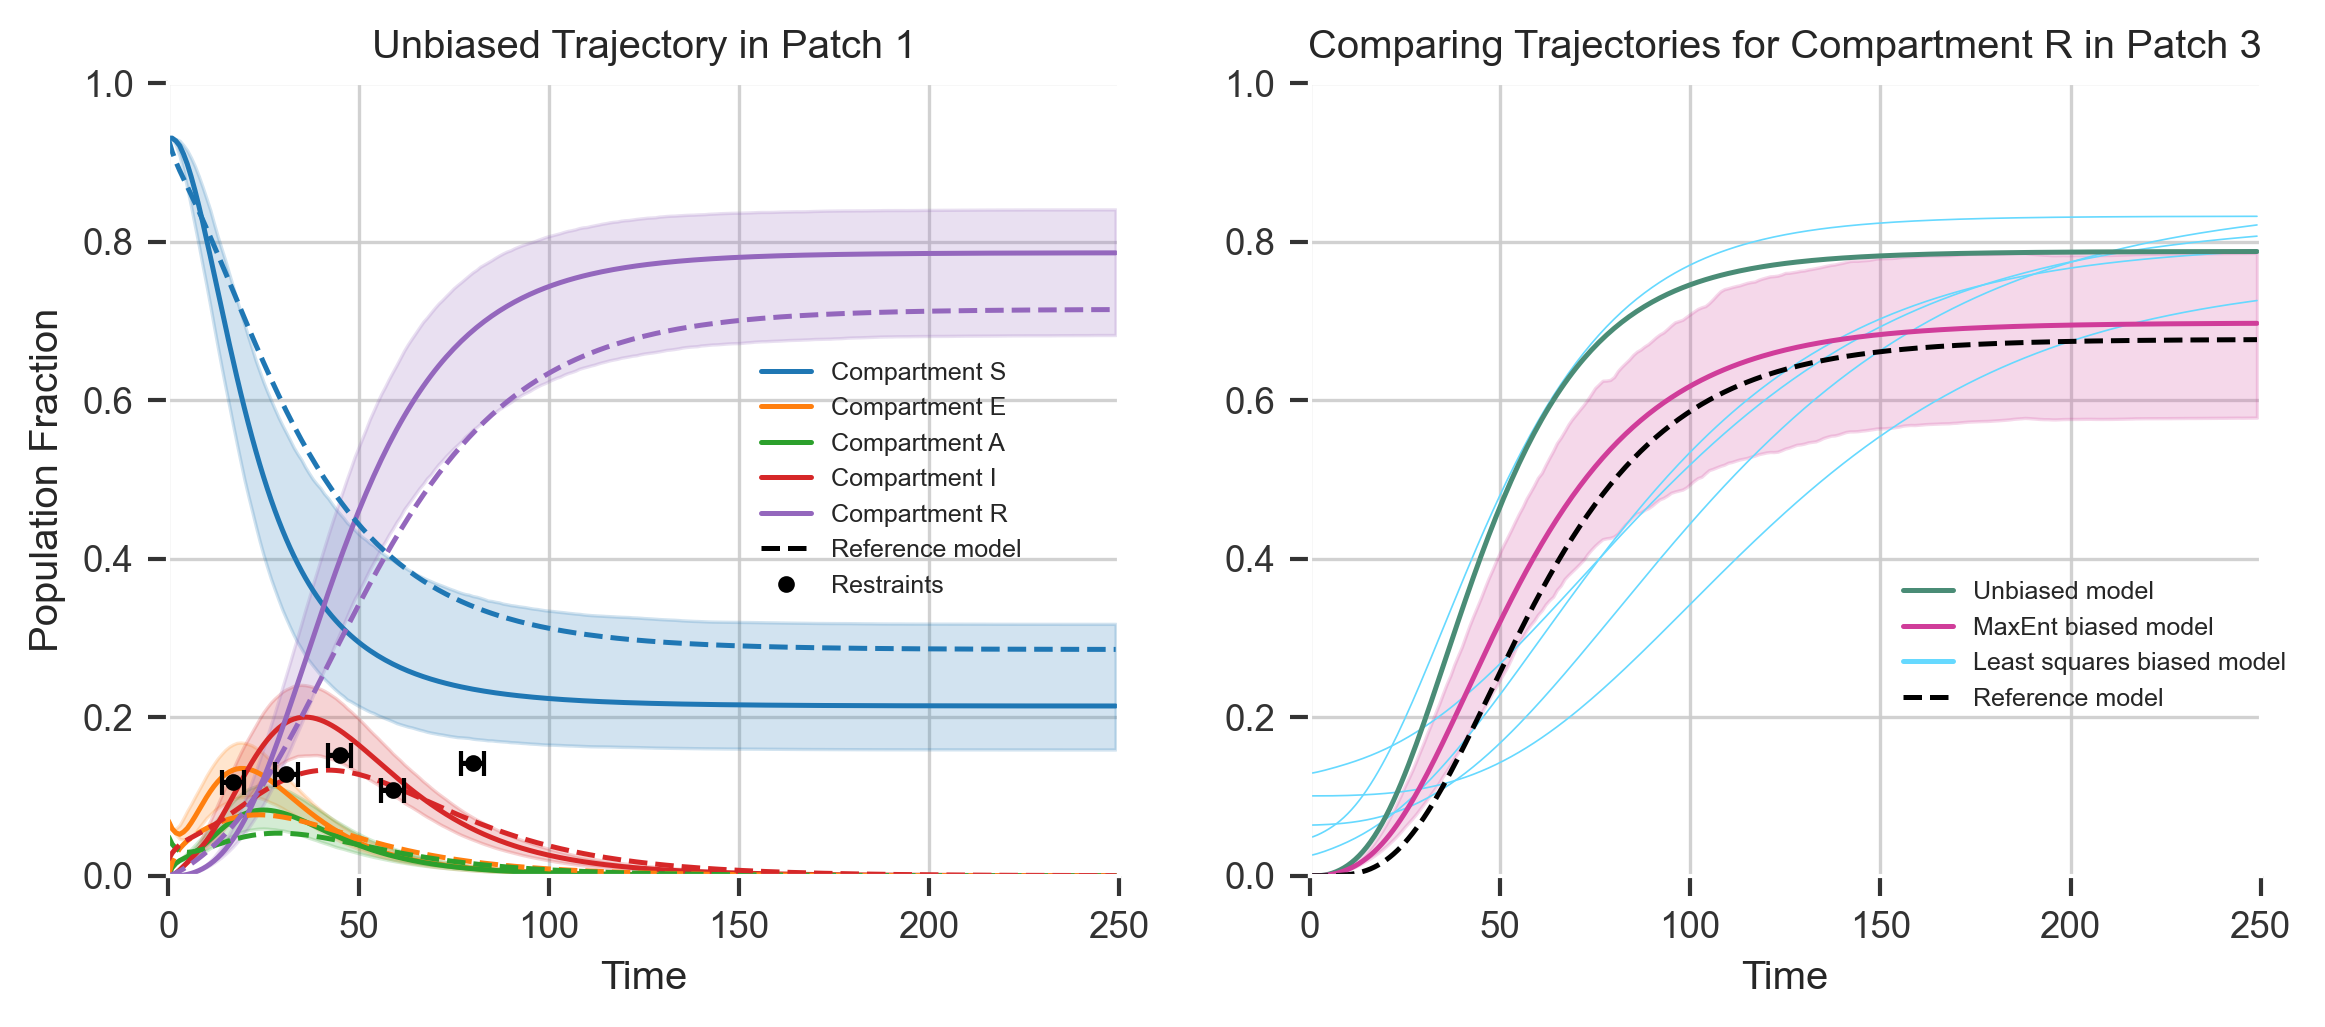

In [109]:
plt.rc('axes', titlesize=8)

import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,3.5), dpi =300)

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'Unbiased Trajectory in Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(0.6,0.5), fontsize=6)


plt.setp(axs[1], xlabel='Time', title = 'Comparing Trajectories for Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_hyperbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_hyperbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_hyperbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[1, :, :] = mtrajs_hyperbiased
print(mtrajs_unbiased.shape)
for i,y in enumerate(LS_sample_trajs):
    axs[1].plot(y[:,2,4], color= '#66d9ff', linewidth=0.4)
axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased model')
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= '#D03D9A',  label='MaxEnt biased model')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
# axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= 'C2',  label='Least squares biased model')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least squares biased model'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#66d9ff')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, ref_label ]
                , bbox_to_anchor=(0.6,0.4), fontsize=6)


plt.savefig('Figure_3.png', transparent=False, dpi = 300)
